In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

In [2]:
inp_u1 = pd.read_csv(r'theta_x_1.csv', header = None)
inputs_u1 = inp_u1.to_numpy()
theta_x1 = inputs_u1[:,0].astype(np.float32)
theta_x2 = inputs_u1[:,1].astype(np.float32)
theta_x3 = inputs_u1[:,2].astype(np.float32)
theta_x4 = inputs_u1[:,3].astype(np.float32)
theta_x5 = inputs_u1[:,4].astype(np.float32)

theta_x1 = torch.from_numpy(theta_x1)
theta_x2 = torch.from_numpy(theta_x2)
theta_x3 = torch.from_numpy(theta_x3)
theta_x4 = torch.from_numpy(theta_x4)
theta_x5 = torch.from_numpy(theta_x5)

In [3]:
# Additional data for acceleration

data_pts = 10000

x_1 = 0*torch.ones((data_pts)).reshape(-1,1)
x_2 = 0.25*pi*torch.ones((data_pts)).reshape(-1,1)
x_3 = 0.5*pi*torch.ones((data_pts)).reshape(-1,1)
x_4 = 0.75*pi*torch.ones((data_pts)).reshape(-1,1)
x_5 = pi*torch.ones((data_pts)).reshape(-1,1)

t_data_pts = torch.rand((data_pts, 1))

fir_loc = torch.cat([x_1, t_data_pts],1)
sec_loc = torch.cat([x_2, t_data_pts],1)
thr_loc = torch.cat([x_3, t_data_pts],1)
fou_loc = torch.cat([x_4, t_data_pts],1)
fif_loc = torch.cat([x_5, t_data_pts],1)


In [16]:
# Define the exact solution (cross-sectional rotation)
def exact_solution_p(x, t):
    return 0.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return 0.5*pi*torch.sin(x)

def initial_condition_p_t(x):
    return 0.0*pi*torch.cos(x) 

In [17]:
# assigning number of points
initial_pts = 2000 
left_boundary_pts = 2000 
right_boundary_pts = 2000
residual_pts = 10000

In [18]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [19]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1)



p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1)

xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)

p_b_l = exact_solution_p(xb_left, tb_left)




xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
p_b_r = exact_solution_p(xb_right, tb_right)


x_interior = pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, p_init, p_t_init, b_left,  b_right), batch_size=2000, shuffle=False)

In [20]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = 1, n_hidden_layers=4, neurons=20)

In [21]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [22]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [23]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, p_initial, p_initial_t, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                p_initial_pred_ = w_initial_pred_.reshape(-1,1)
#                 p_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                
                p_initial_t = grad_p_ini[:, 1]
                
                
#                 grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]
                
#                 p_initial_t = grad_p_ini[:, 1]
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                p_bd_left_pred_ = w_bd_left_pred_.reshape(-1,1)
#                 p_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                p_bd_right_pred_ = w_bd_right_pred_.reshape(-1,1)
#                 p_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                
                # residual calculation
                fir_loc.requires_grad = True
                sec_loc.requires_grad = True
                thr_loc.requires_grad = True
                fou_loc.requires_grad = True
                fif_loc.requires_grad = True
                t_data_pts.requires_grad = True
                x_1.requires_grad = True
                x_2.requires_grad = True
                x_3.requires_grad = True
                x_4.requires_grad = True
                x_5.requires_grad = True
              
                
                w_1 = model(fir_loc)
                w_2 = model(sec_loc)
                w_3 = model(thr_loc)
                w_4 = model(fou_loc)
                w_5 = model(fif_loc)
               
            
            
               
                
                # First Location
                
                u_hat1 = w_1.reshape(-1,1)
                inputs = torch.ones(data_pts, 1 )
                grad_u_hat1 = torch.autograd.grad(u_hat1.reshape(-1,1),  fir_loc, grad_outputs=inputs, create_graph=True)[0]
               
                p_x1 = grad_u_hat1[:, 0].reshape(-1,1)
                
                # Second Location
                u_hat2 = w_2.reshape(-1,1)
                grad_u_hat2 = torch.autograd.grad(u_hat2.reshape(-1,1), sec_loc, grad_outputs=inputs, create_graph=True)[0]
                
                p_x2 = grad_u_hat2[:, 0].reshape(-1,1)
              
                
                # Third Location
                
                u_hat3 = w_3.reshape(-1,1)
                grad_u_hat3 = torch.autograd.grad(u_hat3.reshape(-1,1), thr_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t3 = grad_u_hat3[:, 1].reshape(-1,1)
                p_x3 = grad_u_hat3[:, 0].reshape(-1,1)
                
                # Fourth Location
                
                u_hat4 = w_4.reshape(-1,1)
                grad_u_hat4 = torch.autograd.grad(u_hat4.reshape(-1,1), fou_loc, grad_outputs=inputs, create_graph=True)[0]
                
                p_x4 = grad_u_hat4[:, 0].reshape(-1,1)
                
                 
                # Fifth Location
                
                u_hat5 = w_5.reshape(-1,1)
                grad_u_hat5 = torch.autograd.grad(u_hat5.reshape(-1,1), fif_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t5 = grad_u_hat5[:, 1].reshape(-1,1)
                p_x5 = grad_u_hat5[:, 0].reshape(-1,1)
                
#                 data1 = torch.mean( theta_x1.reshape(-1, )**p)
#                 data2 = torch.mean(theta_x2.reshape(-1, )**p)
#                 data3 = torch.mean(theta_x3.reshape(-1, )**p)
#                 data4 = torch.mean(theta_x4.reshape(-1, )**p)
#                 data5 = torch.mean(theta_x5.reshape(-1, )**p)
                
                
             

             
              
                data1 = torch.mean((theta_x1.reshape(-1, ) - p_x1.reshape(-1, ))**p)
                data2 = torch.mean((theta_x2.reshape(-1, ) - p_x2.reshape(-1, ))**p)
                data3 = torch.mean((theta_x3.reshape(-1, ) - p_x3.reshape(-1, ))**p)
                data4 = torch.mean((theta_x4.reshape(-1, ) - p_x4.reshape(-1, ))**p)
                data5 = torch.mean((theta_x5.reshape(-1, ) - p_x5.reshape(-1, ))**p)
                
                 # Item 1. below
                
                #loss2 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t.reshape(-1, ))**p)+torch.mean((u_initial_pred_.reshape(-1, ) - w_initial.reshape(-1, ))**p) + torch.mean((u_bd_left_pred_.reshape(-1,) - u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,) - u_b_r.reshape(-1,))**p)

                #loss = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:, 0].reshape(-1, ))**p)
                
                #loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:,0].reshape(-1, ))**p)+torch.mean((u_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
                loss1 = torch.mean((p_initial_pred_.reshape(-1, ) - p_initial.reshape(-1, ))**p)+ torch.mean((p_initial_t.reshape(-1, ) - p_initial_t.reshape(-1, ))**p)+torch.mean((p_bd_left_pred_.reshape(-1,)- p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
#                 loss = loss1 + loss2
                #loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))
                loss = loss1 + data1 + data2 + data3 + data4 + data5
                #loss = loss1 
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [24]:
n_epochs = 15000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  63.917747497558594
################################  1  ################################
Loss:  62.309635162353516
################################  2  ################################
Loss:  49.8547248840332
################################  3  ################################
Loss:  17.235578536987305
################################  4  ################################
Loss:  16.27335548400879
################################  5  ################################
Loss:  15.362350463867188
################################  6  ################################
Loss:  14.527527809143066
################################  7  ################################
Loss:  13.782724380493164
################################  8  ################################
Loss:  13.130792617797852
################################  9  ################################
Loss:  12.5676851272583
################################  10  #######

Loss:  5.689167499542236
################################  90  ################################
Loss:  5.6866559982299805
################################  91  ################################
Loss:  5.684011936187744
################################  92  ################################
Loss:  5.681196689605713
################################  93  ################################
Loss:  5.678037643432617
################################  94  ################################
Loss:  5.674462795257568
################################  95  ################################
Loss:  5.6702799797058105
################################  96  ################################
Loss:  5.665374279022217
################################  97  ################################
Loss:  5.65955924987793
################################  98  ################################
Loss:  5.6529436111450195
################################  99  ################################
Loss:  5.646661758422852
#############

Loss:  5.459470748901367
################################  175  ################################
Loss:  5.458513259887695
################################  176  ################################
Loss:  5.457597732543945
################################  177  ################################
Loss:  5.456711769104004
################################  178  ################################
Loss:  5.455848217010498
################################  179  ################################
Loss:  5.455007076263428
################################  180  ################################
Loss:  5.454179763793945
################################  181  ################################
Loss:  5.453380584716797
################################  182  ################################
Loss:  5.452592849731445
################################  183  ################################
Loss:  5.451843738555908
################################  184  ################################
Loss:  5.451114654541016
#####

Loss:  5.394208908081055
################################  260  ################################
Loss:  5.393808841705322
################################  261  ################################
Loss:  5.39341402053833
################################  262  ################################
Loss:  5.393032550811768
################################  263  ################################
Loss:  5.3926544189453125
################################  264  ################################
Loss:  5.392280578613281
################################  265  ################################
Loss:  5.391904354095459
################################  266  ################################
Loss:  5.391529560089111
################################  267  ################################
Loss:  5.391149520874023
################################  268  ################################
Loss:  5.390765190124512
################################  269  ################################
Loss:  5.390371322631836
#####

Loss:  5.359776020050049
################################  347  ################################
Loss:  5.359376907348633
################################  348  ################################
Loss:  5.359022617340088
################################  349  ################################
Loss:  5.358667373657227
################################  350  ################################
Loss:  5.358360767364502
################################  351  ################################
Loss:  5.358060359954834
################################  352  ################################
Loss:  5.357773780822754
################################  353  ################################
Loss:  5.357300281524658
################################  354  ################################
Loss:  5.35698938369751
################################  355  ################################
Loss:  5.35671329498291
################################  356  ################################
Loss:  5.356414318084717
#######

Loss:  5.34138298034668
################################  432  ################################
Loss:  5.34121561050415
################################  433  ################################
Loss:  5.341052055358887
################################  434  ################################
Loss:  5.340909481048584
################################  435  ################################
Loss:  5.340771675109863
################################  436  ################################
Loss:  5.340643405914307
################################  437  ################################
Loss:  5.340517044067383
################################  438  ################################
Loss:  5.340397357940674
################################  439  ################################
Loss:  5.3402791023254395
################################  440  ################################
Loss:  5.340166091918945
################################  441  ################################
Loss:  5.340055465698242
######

Loss:  5.333500862121582
################################  521  ################################
Loss:  5.33344030380249
################################  522  ################################
Loss:  5.3333821296691895
################################  523  ################################
Loss:  5.333323955535889
################################  524  ################################
Loss:  5.333268165588379
################################  525  ################################
Loss:  5.33320951461792
################################  526  ################################
Loss:  5.333151817321777
################################  527  ################################
Loss:  5.333074569702148
################################  528  ################################
Loss:  5.333009243011475
################################  529  ################################
Loss:  5.332942008972168
################################  530  ################################
Loss:  5.332846641540527
######

Loss:  5.328294277191162
################################  607  ################################
Loss:  5.328181743621826
################################  608  ################################
Loss:  5.328071594238281
################################  609  ################################
Loss:  5.327967166900635
################################  610  ################################
Loss:  5.32786226272583
################################  611  ################################
Loss:  5.3277692794799805
################################  612  ################################
Loss:  5.327673435211182
################################  613  ################################
Loss:  5.32756233215332
################################  614  ################################
Loss:  5.327473163604736
################################  615  ################################
Loss:  5.327382564544678
################################  616  ################################
Loss:  5.327295780181885
######

Loss:  5.323903560638428
################################  693  ################################
Loss:  5.323877811431885
################################  694  ################################
Loss:  5.3238525390625
################################  695  ################################
Loss:  5.323829174041748
################################  696  ################################
Loss:  5.323805809020996
################################  697  ################################
Loss:  5.323784828186035
################################  698  ################################
Loss:  5.323765754699707
################################  699  ################################
Loss:  5.32374906539917
################################  700  ################################
Loss:  5.323733329772949
################################  701  ################################
Loss:  5.323719024658203
################################  702  ################################
Loss:  5.323705196380615
########

Loss:  5.321758270263672
################################  780  ################################
Loss:  5.3217453956604
################################  781  ################################
Loss:  5.321734428405762
################################  782  ################################
Loss:  5.321723937988281
################################  783  ################################
Loss:  5.321712493896484
################################  784  ################################
Loss:  5.321702480316162
################################  785  ################################
Loss:  5.321693420410156
################################  786  ################################
Loss:  5.321682929992676
################################  787  ################################
Loss:  5.321673393249512
################################  788  ################################
Loss:  5.321664810180664
################################  789  ################################
Loss:  5.321652412414551
#######

Loss:  5.319668769836426
################################  867  ################################
Loss:  5.319647312164307
################################  868  ################################
Loss:  5.319621562957764
################################  869  ################################
Loss:  5.319602012634277
################################  870  ################################
Loss:  5.319582939147949
################################  871  ################################
Loss:  5.319565773010254
################################  872  ################################
Loss:  5.3195481300354
################################  873  ################################
Loss:  5.319530487060547
################################  874  ################################
Loss:  5.319513320922852
################################  875  ################################
Loss:  5.319495677947998
################################  876  ################################
Loss:  5.319479465484619
#######

Loss:  5.318387508392334
################################  953  ################################
Loss:  5.3183722496032715
################################  954  ################################
Loss:  5.318358898162842
################################  955  ################################
Loss:  5.318344593048096
################################  956  ################################
Loss:  5.318331718444824
################################  957  ################################
Loss:  5.318318843841553
################################  958  ################################
Loss:  5.318305969238281
################################  959  ################################
Loss:  5.318294525146484
################################  960  ################################
Loss:  5.318279266357422
################################  961  ################################
Loss:  5.318268299102783
################################  962  ################################
Loss:  5.318255424499512
####

Loss:  5.317296504974365
################################  1040  ################################
Loss:  5.3172688484191895
################################  1041  ################################
Loss:  5.3172454833984375
################################  1042  ################################
Loss:  5.31722354888916
################################  1043  ################################
Loss:  5.31720495223999
################################  1044  ################################
Loss:  5.317187309265137
################################  1045  ################################
Loss:  5.317173004150391
################################  1046  ################################
Loss:  5.3171586990356445
################################  1047  ################################
Loss:  5.317146301269531
################################  1048  ################################
Loss:  5.317134857177734
################################  1049  ################################
Loss:  5.3171234130

Loss:  5.316827297210693
################################  1124  ################################
Loss:  5.316824913024902
################################  1125  ################################
Loss:  5.316822052001953
################################  1126  ################################
Loss:  5.316819667816162
################################  1127  ################################
Loss:  5.3168182373046875
################################  1128  ################################
Loss:  5.316816329956055
################################  1129  ################################
Loss:  5.31681489944458
################################  1130  ################################
Loss:  5.316812515258789
################################  1131  ################################
Loss:  5.3168110847473145
################################  1132  ################################
Loss:  5.316810131072998
################################  1133  ################################
Loss:  5.3168087005

Loss:  5.31659460067749
################################  1212  ################################
Loss:  5.316585063934326
################################  1213  ################################
Loss:  5.3165764808654785
################################  1214  ################################
Loss:  5.316568851470947
################################  1215  ################################
Loss:  5.3165602684021
################################  1216  ################################
Loss:  5.316553115844727
################################  1217  ################################
Loss:  5.316547870635986
################################  1218  ################################
Loss:  5.316540718078613
################################  1219  ################################
Loss:  5.316534996032715
################################  1220  ################################
Loss:  5.316531181335449
################################  1221  ################################
Loss:  5.3165268898010

Loss:  5.31634521484375
################################  1300  ################################
Loss:  5.316342353820801
################################  1301  ################################
Loss:  5.316339015960693
################################  1302  ################################
Loss:  5.316336631774902
################################  1303  ################################
Loss:  5.3163323402404785
################################  1304  ################################
Loss:  5.316328525543213
################################  1305  ################################
Loss:  5.316325664520264
################################  1306  ################################
Loss:  5.316320896148682
################################  1307  ################################
Loss:  5.3163161277771
################################  1308  ################################
Loss:  5.316311359405518
################################  1309  ################################
Loss:  5.3163056373596

Loss:  5.316163063049316
################################  1387  ################################
Loss:  5.316161155700684
################################  1388  ################################
Loss:  5.316160202026367
################################  1389  ################################
Loss:  5.316158294677734
################################  1390  ################################
Loss:  5.316155433654785
################################  1391  ################################
Loss:  5.316153526306152
################################  1392  ################################
Loss:  5.316149711608887
################################  1393  ################################
Loss:  5.316147804260254
################################  1394  ################################
Loss:  5.316145896911621
################################  1395  ################################
Loss:  5.316143035888672
################################  1396  ################################
Loss:  5.31614017486

Loss:  5.315960884094238
################################  1475  ################################
Loss:  5.315954685211182
################################  1476  ################################
Loss:  5.315946578979492
################################  1477  ################################
Loss:  5.315938949584961
################################  1478  ################################
Loss:  5.315928936004639
################################  1479  ################################
Loss:  5.315919399261475
################################  1480  ################################
Loss:  5.315908908843994
################################  1481  ################################
Loss:  5.315900802612305
################################  1482  ################################
Loss:  5.315890312194824
################################  1483  ################################
Loss:  5.31588077545166
################################  1484  ################################
Loss:  5.315873146057

Loss:  5.314469337463379
################################  1559  ################################
Loss:  5.314456939697266
################################  1560  ################################
Loss:  5.3144450187683105
################################  1561  ################################
Loss:  5.314433574676514
################################  1562  ################################
Loss:  5.31442403793335
################################  1563  ################################
Loss:  5.314413070678711
################################  1564  ################################
Loss:  5.314411640167236
################################  1565  ################################
Loss:  5.314401626586914
################################  1566  ################################
Loss:  5.314392566680908
################################  1567  ################################
Loss:  5.3143839836120605
################################  1568  ################################
Loss:  5.3143754005

Loss:  5.314239501953125
################################  1645  ################################
Loss:  5.314238548278809
################################  1646  ################################
Loss:  5.314237594604492
################################  1647  ################################
Loss:  5.314236164093018
################################  1648  ################################
Loss:  5.314233779907227
################################  1649  ################################
Loss:  5.314232349395752
################################  1650  ################################
Loss:  5.3142313957214355
################################  1651  ################################
Loss:  5.314230442047119
################################  1652  ################################
Loss:  5.3142290115356445
################################  1653  ################################
Loss:  5.314227104187012
################################  1654  ################################
Loss:  5.314226150

Loss:  5.313938617706299
################################  1731  ################################
Loss:  5.313932418823242
################################  1732  ################################
Loss:  5.313928604125977
################################  1733  ################################
Loss:  5.3139190673828125
################################  1734  ################################
Loss:  5.313912391662598
################################  1735  ################################
Loss:  5.313907146453857
################################  1736  ################################
Loss:  5.313900470733643
################################  1737  ################################
Loss:  5.3138933181762695
################################  1738  ################################
Loss:  5.313886642456055
################################  1739  ################################
Loss:  5.313880443572998
################################  1740  ################################
Loss:  5.313873291

Loss:  5.313633441925049
################################  1815  ################################
Loss:  5.313632011413574
################################  1816  ################################
Loss:  5.313630104064941
################################  1817  ################################
Loss:  5.31362771987915
################################  1818  ################################
Loss:  5.313624858856201
################################  1819  ################################
Loss:  5.313621997833252
################################  1820  ################################
Loss:  5.313619136810303
################################  1821  ################################
Loss:  5.313614845275879
################################  1822  ################################
Loss:  5.313610553741455
################################  1823  ################################
Loss:  5.313604831695557
################################  1824  ################################
Loss:  5.313600063323

Loss:  5.313301086425781
################################  1900  ################################
Loss:  5.313299179077148
################################  1901  ################################
Loss:  5.313297748565674
################################  1902  ################################
Loss:  5.313297748565674
################################  1903  ################################
Loss:  5.313295841217041
################################  1904  ################################
Loss:  5.313294887542725
################################  1905  ################################
Loss:  5.313294410705566
################################  1906  ################################
Loss:  5.313292503356934
################################  1907  ################################
Loss:  5.313290596008301
################################  1908  ################################
Loss:  5.313290596008301
################################  1909  ################################
Loss:  5.31328964233

Loss:  5.312996864318848
################################  1987  ################################
Loss:  5.312983512878418
################################  1988  ################################
Loss:  5.3129706382751465
################################  1989  ################################
Loss:  5.312959671020508
################################  1990  ################################
Loss:  5.312949180603027
################################  1991  ################################
Loss:  5.31294059753418
################################  1992  ################################
Loss:  5.31293249130249
################################  1993  ################################
Loss:  5.312925815582275
################################  1994  ################################
Loss:  5.3129191398620605
################################  1995  ################################
Loss:  5.312913417816162
################################  1996  ################################
Loss:  5.31290769577

Loss:  5.312384128570557
################################  2071  ################################
Loss:  5.312374591827393
################################  2072  ################################
Loss:  5.312366008758545
################################  2073  ################################
Loss:  5.312355995178223
################################  2074  ################################
Loss:  5.312346935272217
################################  2075  ################################
Loss:  5.3123250007629395
################################  2076  ################################
Loss:  5.312321186065674
################################  2077  ################################
Loss:  5.312317848205566
################################  2078  ################################
Loss:  5.312313079833984
################################  2079  ################################
Loss:  5.312309265136719
################################  2080  ################################
Loss:  5.3123044967

Loss:  5.311894416809082
################################  2155  ################################
Loss:  5.311891078948975
################################  2156  ################################
Loss:  5.311885833740234
################################  2157  ################################
Loss:  5.311880111694336
################################  2158  ################################
Loss:  5.3118743896484375
################################  2159  ################################
Loss:  5.311868190765381
################################  2160  ################################
Loss:  5.311859607696533
################################  2161  ################################
Loss:  5.3118510246276855
################################  2162  ################################
Loss:  5.3118414878845215
################################  2163  ################################
Loss:  5.311830997467041
################################  2164  ################################
Loss:  5.31182193

Loss:  5.311336040496826
################################  2242  ################################
Loss:  5.3113298416137695
################################  2243  ################################
Loss:  5.311326026916504
################################  2244  ################################
Loss:  5.31132173538208
################################  2245  ################################
Loss:  5.311316013336182
################################  2246  ################################
Loss:  5.311312198638916
################################  2247  ################################
Loss:  5.311306476593018
################################  2248  ################################
Loss:  5.311302661895752
################################  2249  ################################
Loss:  5.311297416687012
################################  2250  ################################
Loss:  5.311293601989746
################################  2251  ################################
Loss:  5.31128978729

Loss:  5.310868263244629
################################  2328  ################################
Loss:  5.3108649253845215
################################  2329  ################################
Loss:  5.310861587524414
################################  2330  ################################
Loss:  5.310859203338623
################################  2331  ################################
Loss:  5.310856342315674
################################  2332  ################################
Loss:  5.310853481292725
################################  2333  ################################
Loss:  5.310850620269775
################################  2334  ################################
Loss:  5.310847759246826
################################  2335  ################################
Loss:  5.310845375061035
################################  2336  ################################
Loss:  5.310842037200928
################################  2337  ################################
Loss:  5.3108386993

Loss:  5.310694694519043
################################  2415  ################################
Loss:  5.310693740844727
################################  2416  ################################
Loss:  5.310690402984619
################################  2417  ################################
Loss:  5.310687065124512
################################  2418  ################################
Loss:  5.310683727264404
################################  2419  ################################
Loss:  5.310678958892822
################################  2420  ################################
Loss:  5.3106770515441895
################################  2421  ################################
Loss:  5.310672760009766
################################  2422  ################################
Loss:  5.310669898986816
################################  2423  ################################
Loss:  5.310666561126709
################################  2424  ################################
Loss:  5.3106627464

Loss:  5.310390472412109
################################  2502  ################################
Loss:  5.3103861808776855
################################  2503  ################################
Loss:  5.310390472412109
################################  2504  ################################
Loss:  5.310386657714844
################################  2505  ################################
Loss:  5.310382843017578
################################  2506  ################################
Loss:  5.3103790283203125
################################  2507  ################################
Loss:  5.310375690460205
################################  2508  ################################
Loss:  5.3103718757629395
################################  2509  ################################
Loss:  5.310368537902832
################################  2510  ################################
Loss:  5.310365676879883
################################  2511  ################################
Loss:  5.31036281

Loss:  5.310313701629639
################################  2590  ################################
Loss:  5.3103132247924805
################################  2591  ################################
Loss:  5.310312747955322
################################  2592  ################################
Loss:  5.310311794281006
################################  2593  ################################
Loss:  5.310308933258057
################################  2594  ################################
Loss:  5.310307025909424
################################  2595  ################################
Loss:  5.310304164886475
################################  2596  ################################
Loss:  5.310301780700684
################################  2597  ################################
Loss:  5.310298442840576
################################  2598  ################################
Loss:  5.310295581817627
################################  2599  ################################
Loss:  5.3102946281

Loss:  5.310063362121582
################################  2676  ################################
Loss:  5.31005859375
################################  2677  ################################
Loss:  5.310054302215576
################################  2678  ################################
Loss:  5.3100481033325195
################################  2679  ################################
Loss:  5.3100433349609375
################################  2680  ################################
Loss:  5.3100385665893555
################################  2681  ################################
Loss:  5.310033798217773
################################  2682  ################################
Loss:  5.310028076171875
################################  2683  ################################
Loss:  5.310020923614502
################################  2684  ################################
Loss:  5.310009002685547
################################  2685  ################################
Loss:  5.310003280639

Loss:  5.309789180755615
################################  2762  ################################
Loss:  5.309788703918457
################################  2763  ################################
Loss:  5.309787273406982
################################  2764  ################################
Loss:  5.309786796569824
################################  2765  ################################
Loss:  5.309783935546875
################################  2766  ################################
Loss:  5.309783458709717
################################  2767  ################################
Loss:  5.3097825050354
################################  2768  ################################
Loss:  5.309780597686768
################################  2769  ################################
Loss:  5.309779644012451
################################  2770  ################################
Loss:  5.309778213500977
################################  2771  ################################
Loss:  5.3097777366638

Loss:  5.309671401977539
################################  2849  ################################
Loss:  5.309669017791748
################################  2850  ################################
Loss:  5.309667587280273
################################  2851  ################################
Loss:  5.309667110443115
################################  2852  ################################
Loss:  5.309673309326172
################################  2853  ################################
Loss:  5.309670448303223
################################  2854  ################################
Loss:  5.309669494628906
################################  2855  ################################
Loss:  5.309667110443115
################################  2856  ################################
Loss:  5.309665679931641
################################  2857  ################################
Loss:  5.309664249420166
################################  2858  ################################
Loss:  5.30966234207

Loss:  5.309627532958984
################################  2935  ################################
Loss:  5.309627532958984
################################  2936  ################################
Loss:  5.309627532958984
################################  2937  ################################
Loss:  5.30962610244751
################################  2938  ################################
Loss:  5.309626579284668
################################  2939  ################################
Loss:  5.309625625610352
################################  2940  ################################
Loss:  5.309625625610352
################################  2941  ################################
Loss:  5.309625148773193
################################  2942  ################################
Loss:  5.309624671936035
################################  2943  ################################
Loss:  5.309623718261719
################################  2944  ################################
Loss:  5.309623718261

Loss:  5.309580326080322
################################  3021  ################################
Loss:  5.309578895568848
################################  3022  ################################
Loss:  5.309577465057373
################################  3023  ################################
Loss:  5.30957555770874
################################  3024  ################################
Loss:  5.309574127197266
################################  3025  ################################
Loss:  5.309573173522949
################################  3026  ################################
Loss:  5.309572696685791
################################  3027  ################################
Loss:  5.309571266174316
################################  3028  ################################
Loss:  5.309571266174316
################################  3029  ################################
Loss:  5.3095703125
################################  3030  ################################
Loss:  5.309569358825684
#

Loss:  5.309532642364502
################################  3109  ################################
Loss:  5.309532642364502
################################  3110  ################################
Loss:  5.309531211853027
################################  3111  ################################
Loss:  5.309531211853027
################################  3112  ################################
Loss:  5.309531211853027
################################  3113  ################################
Loss:  5.309530735015869
################################  3114  ################################
Loss:  5.309529781341553
################################  3115  ################################
Loss:  5.309529781341553
################################  3116  ################################
Loss:  5.309529781341553
################################  3117  ################################
Loss:  5.309530258178711
################################  3118  ################################
Loss:  5.30952930450

Loss:  5.309510707855225
################################  3196  ################################
Loss:  5.309509754180908
################################  3197  ################################
Loss:  5.309510707855225
################################  3198  ################################
Loss:  5.309509754180908
################################  3199  ################################
Loss:  5.30950927734375
################################  3200  ################################
Loss:  5.30950927734375
################################  3201  ################################
Loss:  5.309508800506592
################################  3202  ################################
Loss:  5.309508800506592
################################  3203  ################################
Loss:  5.309508800506592
################################  3204  ################################
Loss:  5.309508800506592
################################  3205  ################################
Loss:  5.3095083236694

Loss:  5.309460163116455
################################  3281  ################################
Loss:  5.309459209442139
################################  3282  ################################
Loss:  5.309457302093506
################################  3283  ################################
Loss:  5.309457302093506
################################  3284  ################################
Loss:  5.3094563484191895
################################  3285  ################################
Loss:  5.309455394744873
################################  3286  ################################
Loss:  5.309454441070557
################################  3287  ################################
Loss:  5.309453964233398
################################  3288  ################################
Loss:  5.30945348739624
################################  3289  ################################
Loss:  5.309453010559082
################################  3290  ################################
Loss:  5.30945205688

Loss:  5.309326648712158
################################  3366  ################################
Loss:  5.309324264526367
################################  3367  ################################
Loss:  5.309322834014893
################################  3368  ################################
Loss:  5.30932092666626
################################  3369  ################################
Loss:  5.309319496154785
################################  3370  ################################
Loss:  5.3093180656433105
################################  3371  ################################
Loss:  5.309316158294678
################################  3372  ################################
Loss:  5.3093156814575195
################################  3373  ################################
Loss:  5.309314250946045
################################  3374  ################################
Loss:  5.309314250946045
################################  3375  ################################
Loss:  5.3093118667

Loss:  5.309229850769043
################################  3453  ################################
Loss:  5.309229850769043
################################  3454  ################################
Loss:  5.309229850769043
################################  3455  ################################
Loss:  5.309228420257568
################################  3456  ################################
Loss:  5.30922794342041
################################  3457  ################################
Loss:  5.30922794342041
################################  3458  ################################
Loss:  5.3092265129089355
################################  3459  ################################
Loss:  5.309225559234619
################################  3460  ################################
Loss:  5.309225559234619
################################  3461  ################################
Loss:  5.309224605560303
################################  3462  ################################
Loss:  5.309223651885

Loss:  5.30913782119751
################################  3540  ################################
Loss:  5.30913782119751
################################  3541  ################################
Loss:  5.309136867523193
################################  3542  ################################
Loss:  5.309135437011719
################################  3543  ################################
Loss:  5.3091349601745605
################################  3544  ################################
Loss:  5.309133529663086
################################  3545  ################################
Loss:  5.309133052825928
################################  3546  ################################
Loss:  5.309133529663086
################################  3547  ################################
Loss:  5.309133529663086
################################  3548  ################################
Loss:  5.3091325759887695
################################  3549  ################################
Loss:  5.30913162231

Loss:  5.309043884277344
################################  3625  ################################
Loss:  5.3090410232543945
################################  3626  ################################
Loss:  5.309040546417236
################################  3627  ################################
Loss:  5.309039115905762
################################  3628  ################################
Loss:  5.309037685394287
################################  3629  ################################
Loss:  5.3090362548828125
################################  3630  ################################
Loss:  5.309035778045654
################################  3631  ################################
Loss:  5.309034824371338
################################  3632  ################################
Loss:  5.3090338706970215
################################  3633  ################################
Loss:  5.3090338706970215
################################  3634  ################################
Loss:  5.3090324

Loss:  5.308910846710205
################################  3713  ################################
Loss:  5.3089094161987305
################################  3714  ################################
Loss:  5.308907508850098
################################  3715  ################################
Loss:  5.308906555175781
################################  3716  ################################
Loss:  5.308905601501465
################################  3717  ################################
Loss:  5.30890417098999
################################  3718  ################################
Loss:  5.308902740478516
################################  3719  ################################
Loss:  5.308902263641357
################################  3720  ################################
Loss:  5.308900356292725
################################  3721  ################################
Loss:  5.308899402618408
################################  3722  ################################
Loss:  5.30889797210

Loss:  5.308849811553955
################################  3798  ################################
Loss:  5.308849334716797
################################  3799  ################################
Loss:  5.308848857879639
################################  3800  ################################
Loss:  5.308848857879639
################################  3801  ################################
Loss:  5.3088483810424805
################################  3802  ################################
Loss:  5.3088483810424805
################################  3803  ################################
Loss:  5.308847904205322
################################  3804  ################################
Loss:  5.308847427368164
################################  3805  ################################
Loss:  5.308846950531006
################################  3806  ################################
Loss:  5.308846473693848
################################  3807  ################################
Loss:  5.308845520

Loss:  5.308762550354004
################################  3884  ################################
Loss:  5.3087615966796875
################################  3885  ################################
Loss:  5.308761119842529
################################  3886  ################################
Loss:  5.308762073516846
################################  3887  ################################
Loss:  5.308761119842529
################################  3888  ################################
Loss:  5.308760643005371
################################  3889  ################################
Loss:  5.308760643005371
################################  3890  ################################
Loss:  5.308759689331055
################################  3891  ################################
Loss:  5.3087592124938965
################################  3892  ################################
Loss:  5.3087592124938965
################################  3893  ################################
Loss:  5.30875921

Loss:  5.308714389801025
################################  3970  ################################
Loss:  5.308714389801025
################################  3971  ################################
Loss:  5.308713912963867
################################  3972  ################################
Loss:  5.308712959289551
################################  3973  ################################
Loss:  5.308712959289551
################################  3974  ################################
Loss:  5.308712005615234
################################  3975  ################################
Loss:  5.308711051940918
################################  3976  ################################
Loss:  5.308711051940918
################################  3977  ################################
Loss:  5.30871057510376
################################  3978  ################################
Loss:  5.308708190917969
################################  3979  ################################
Loss:  5.308707237243

Loss:  5.308597087860107
################################  4057  ################################
Loss:  5.308594703674316
################################  4058  ################################
Loss:  5.30859375
################################  4059  ################################
Loss:  5.308592319488525
################################  4060  ################################
Loss:  5.308591365814209
################################  4061  ################################
Loss:  5.308589458465576
################################  4062  ################################
Loss:  5.308587551116943
################################  4063  ################################
Loss:  5.308586597442627
################################  4064  ################################
Loss:  5.308585166931152
################################  4065  ################################
Loss:  5.308584690093994
################################  4066  ################################
Loss:  5.3085832595825195
#

Loss:  5.308472633361816
################################  4145  ################################
Loss:  5.308469772338867
################################  4146  ################################
Loss:  5.308466911315918
################################  4147  ################################
Loss:  5.308465003967285
################################  4148  ################################
Loss:  5.308462619781494
################################  4149  ################################
Loss:  5.308460235595703
################################  4150  ################################
Loss:  5.308459281921387
################################  4151  ################################
Loss:  5.308457374572754
################################  4152  ################################
Loss:  5.308455944061279
################################  4153  ################################
Loss:  5.30845308303833
################################  4154  ################################
Loss:  5.308451652526

Loss:  5.3082780838012695
################################  4231  ################################
Loss:  5.308277130126953
################################  4232  ################################
Loss:  5.308287143707275
################################  4233  ################################
Loss:  5.308282375335693
################################  4234  ################################
Loss:  5.3082804679870605
################################  4235  ################################
Loss:  5.308276176452637
################################  4236  ################################
Loss:  5.308274745941162
################################  4237  ################################
Loss:  5.308272361755371
################################  4238  ################################
Loss:  5.308270454406738
################################  4239  ################################
Loss:  5.308268070220947
################################  4240  ################################
Loss:  5.308267593

Loss:  5.308223724365234
################################  4318  ################################
Loss:  5.308223247528076
################################  4319  ################################
Loss:  5.308223724365234
################################  4320  ################################
Loss:  5.30822229385376
################################  4321  ################################
Loss:  5.30822229385376
################################  4322  ################################
Loss:  5.308221340179443
################################  4323  ################################
Loss:  5.308220863342285
################################  4324  ################################
Loss:  5.308220386505127
################################  4325  ################################
Loss:  5.308218955993652
################################  4326  ################################
Loss:  5.308218479156494
################################  4327  ################################
Loss:  5.3082165718078

Loss:  5.308152675628662
################################  4405  ################################
Loss:  5.30814266204834
################################  4406  ################################
Loss:  5.308135032653809
################################  4407  ################################
Loss:  5.308128833770752
################################  4408  ################################
Loss:  5.308122634887695
################################  4409  ################################
Loss:  5.3081183433532715
################################  4410  ################################
Loss:  5.308113098144531
################################  4411  ################################
Loss:  5.308110237121582
################################  4412  ################################
Loss:  5.308107376098633
################################  4413  ################################
Loss:  5.30810546875
################################  4414  ################################
Loss:  5.308102607727051

Loss:  5.308065414428711
################################  4491  ################################
Loss:  5.308064937591553
################################  4492  ################################
Loss:  5.308064937591553
################################  4493  ################################
Loss:  5.308064937591553
################################  4494  ################################
Loss:  5.308065414428711
################################  4495  ################################
Loss:  5.308064937591553
################################  4496  ################################
Loss:  5.308063983917236
################################  4497  ################################
Loss:  5.3080644607543945
################################  4498  ################################
Loss:  5.3080644607543945
################################  4499  ################################
Loss:  5.308063507080078
################################  4500  ################################
Loss:  5.308063983

Loss:  5.308004856109619
################################  4575  ################################
Loss:  5.308004379272461
################################  4576  ################################
Loss:  5.308003902435303
################################  4577  ################################
Loss:  5.308002471923828
################################  4578  ################################
Loss:  5.308002471923828
################################  4579  ################################
Loss:  5.308001518249512
################################  4580  ################################
Loss:  5.307999610900879
################################  4581  ################################
Loss:  5.307999610900879
################################  4582  ################################
Loss:  5.3079986572265625
################################  4583  ################################
Loss:  5.3079986572265625
################################  4584  ################################
Loss:  5.307997226

Loss:  5.3078932762146
################################  4660  ################################
Loss:  5.307891368865967
################################  4661  ################################
Loss:  5.307889938354492
################################  4662  ################################
Loss:  5.307888031005859
################################  4663  ################################
Loss:  5.307885646820068
################################  4664  ################################
Loss:  5.307884216308594
################################  4665  ################################
Loss:  5.307880878448486
################################  4666  ################################
Loss:  5.307878017425537
################################  4667  ################################
Loss:  5.307875633239746
################################  4668  ################################
Loss:  5.307873725891113
################################  4669  ################################
Loss:  5.3078718185424

Loss:  5.3078155517578125
################################  4747  ################################
Loss:  5.307814598083496
################################  4748  ################################
Loss:  5.307814121246338
################################  4749  ################################
Loss:  5.307812690734863
################################  4750  ################################
Loss:  5.3078107833862305
################################  4751  ################################
Loss:  5.307809829711914
################################  4752  ################################
Loss:  5.307808876037598
################################  4753  ################################
Loss:  5.3078083992004395
################################  4754  ################################
Loss:  5.307806491851807
################################  4755  ################################
Loss:  5.30780553817749
################################  4756  ################################
Loss:  5.307805061

Loss:  5.307712554931641
################################  4835  ################################
Loss:  5.307710647583008
################################  4836  ################################
Loss:  5.307709693908691
################################  4837  ################################
Loss:  5.307708740234375
################################  4838  ################################
Loss:  5.3077073097229
################################  4839  ################################
Loss:  5.307706832885742
################################  4840  ################################
Loss:  5.307705402374268
################################  4841  ################################
Loss:  5.307704925537109
################################  4842  ################################
Loss:  5.307704925537109
################################  4843  ################################
Loss:  5.307703495025635
################################  4844  ################################
Loss:  5.3077030181884

Loss:  5.307652950286865
################################  4919  ################################
Loss:  5.307651996612549
################################  4920  ################################
Loss:  5.307651996612549
################################  4921  ################################
Loss:  5.307652473449707
################################  4922  ################################
Loss:  5.307651996612549
################################  4923  ################################
Loss:  5.307651042938232
################################  4924  ################################
Loss:  5.307651042938232
################################  4925  ################################
Loss:  5.307650089263916
################################  4926  ################################
Loss:  5.307650089263916
################################  4927  ################################
Loss:  5.307650566101074
################################  4928  ################################
Loss:  5.30765008926

Loss:  5.307613372802734
################################  5006  ################################
Loss:  5.307612419128418
################################  5007  ################################
Loss:  5.307611465454102
################################  5008  ################################
Loss:  5.307611465454102
################################  5009  ################################
Loss:  5.307610511779785
################################  5010  ################################
Loss:  5.307609558105469
################################  5011  ################################
Loss:  5.307608604431152
################################  5012  ################################
Loss:  5.307608127593994
################################  5013  ################################
Loss:  5.307606220245361
################################  5014  ################################
Loss:  5.307604789733887
################################  5015  ################################
Loss:  5.30760383605

Loss:  5.307538986206055
################################  5092  ################################
Loss:  5.307536602020264
################################  5093  ################################
Loss:  5.3075361251831055
################################  5094  ################################
Loss:  5.307535171508789
################################  5095  ################################
Loss:  5.307534217834473
################################  5096  ################################
Loss:  5.3075337409973145
################################  5097  ################################
Loss:  5.307533264160156
################################  5098  ################################
Loss:  5.307532787322998
################################  5099  ################################
Loss:  5.307531833648682
################################  5100  ################################
Loss:  5.307530879974365
################################  5101  ################################
Loss:  5.307530403

Loss:  5.307490348815918
################################  5177  ################################
Loss:  5.307490825653076
################################  5178  ################################
Loss:  5.307490825653076
################################  5179  ################################
Loss:  5.307490348815918
################################  5180  ################################
Loss:  5.30748987197876
################################  5181  ################################
Loss:  5.307490348815918
################################  5182  ################################
Loss:  5.307489395141602
################################  5183  ################################
Loss:  5.30748987197876
################################  5184  ################################
Loss:  5.307489395141602
################################  5185  ################################
Loss:  5.30748987197876
################################  5186  ################################
Loss:  5.30748939514160

Loss:  5.307486534118652
################################  5263  ################################
Loss:  5.307486534118652
################################  5264  ################################
Loss:  5.307486534118652
################################  5265  ################################
Loss:  5.307486534118652
################################  5266  ################################
Loss:  5.307486057281494
################################  5267  ################################
Loss:  5.307486534118652
################################  5268  ################################
Loss:  5.307486534118652
################################  5269  ################################
Loss:  5.307486534118652
################################  5270  ################################
Loss:  5.307486057281494
################################  5271  ################################
Loss:  5.307485580444336
################################  5272  ################################
Loss:  5.30748605728

Loss:  5.307468891143799
################################  5349  ################################
Loss:  5.307466983795166
################################  5350  ################################
Loss:  5.307467460632324
################################  5351  ################################
Loss:  5.307466983795166
################################  5352  ################################
Loss:  5.307466983795166
################################  5353  ################################
Loss:  5.30746603012085
################################  5354  ################################
Loss:  5.307465553283691
################################  5355  ################################
Loss:  5.30746603012085
################################  5356  ################################
Loss:  5.307465553283691
################################  5357  ################################
Loss:  5.307465076446533
################################  5358  ################################
Loss:  5.3074650764465

Loss:  5.307453155517578
################################  5436  ################################
Loss:  5.307453155517578
################################  5437  ################################
Loss:  5.307453632354736
################################  5438  ################################
Loss:  5.307453632354736
################################  5439  ################################
Loss:  5.307453155517578
################################  5440  ################################
Loss:  5.307453155517578
################################  5441  ################################
Loss:  5.307452201843262
################################  5442  ################################
Loss:  5.3074517250061035
################################  5443  ################################
Loss:  5.307452201843262
################################  5444  ################################
Loss:  5.3074517250061035
################################  5445  ################################
Loss:  5.307451248

Loss:  5.307431697845459
################################  5520  ################################
Loss:  5.307431697845459
################################  5521  ################################
Loss:  5.307431221008301
################################  5522  ################################
Loss:  5.307431697845459
################################  5523  ################################
Loss:  5.307431221008301
################################  5524  ################################
Loss:  5.307430744171143
################################  5525  ################################
Loss:  5.307430744171143
################################  5526  ################################
Loss:  5.307430267333984
################################  5527  ################################
Loss:  5.307430267333984
################################  5528  ################################
Loss:  5.307430744171143
################################  5529  ################################
Loss:  5.30743026733

Loss:  5.307412624359131
################################  5606  ################################
Loss:  5.307412147521973
################################  5607  ################################
Loss:  5.307412624359131
################################  5608  ################################
Loss:  5.307411193847656
################################  5609  ################################
Loss:  5.307411193847656
################################  5610  ################################
Loss:  5.307411193847656
################################  5611  ################################
Loss:  5.307410717010498
################################  5612  ################################
Loss:  5.307408809661865
################################  5613  ################################
Loss:  5.307409286499023
################################  5614  ################################
Loss:  5.307408332824707
################################  5615  ################################
Loss:  5.30740642547

Loss:  5.307356834411621
################################  5694  ################################
Loss:  5.307356834411621
################################  5695  ################################
Loss:  5.307356834411621
################################  5696  ################################
Loss:  5.307356834411621
################################  5697  ################################
Loss:  5.307356357574463
################################  5698  ################################
Loss:  5.307357311248779
################################  5699  ################################
Loss:  5.307357311248779
################################  5700  ################################
Loss:  5.307356834411621
################################  5701  ################################
Loss:  5.307356357574463
################################  5702  ################################
Loss:  5.307354927062988
################################  5703  ################################
Loss:  5.30735540390

Loss:  5.307338714599609
################################  5778  ################################
Loss:  5.307338714599609
################################  5779  ################################
Loss:  5.307339668273926
################################  5780  ################################
Loss:  5.307338714599609
################################  5781  ################################
Loss:  5.307339191436768
################################  5782  ################################
Loss:  5.307339191436768
################################  5783  ################################
Loss:  5.307338714599609
################################  5784  ################################
Loss:  5.307339191436768
################################  5785  ################################
Loss:  5.307338714599609
################################  5786  ################################
Loss:  5.307338714599609
################################  5787  ################################
Loss:  5.30733871459

Loss:  5.307312488555908
################################  5867  ################################
Loss:  5.307312488555908
################################  5868  ################################
Loss:  5.30731201171875
################################  5869  ################################
Loss:  5.307311058044434
################################  5870  ################################
Loss:  5.307310581207275
################################  5871  ################################
Loss:  5.307310104370117
################################  5872  ################################
Loss:  5.307309150695801
################################  5873  ################################
Loss:  5.307309150695801
################################  5874  ################################
Loss:  5.307308673858643
################################  5875  ################################
Loss:  5.307307720184326
################################  5876  ################################
Loss:  5.307307720184

Loss:  5.30728006362915
################################  5952  ################################
Loss:  5.307280540466309
################################  5953  ################################
Loss:  5.30728006362915
################################  5954  ################################
Loss:  5.30728006362915
################################  5955  ################################
Loss:  5.307279109954834
################################  5956  ################################
Loss:  5.307279586791992
################################  5957  ################################
Loss:  5.307279109954834
################################  5958  ################################
Loss:  5.307278156280518
################################  5959  ################################
Loss:  5.307278156280518
################################  5960  ################################
Loss:  5.307278156280518
################################  5961  ################################
Loss:  5.30727815628051

Loss:  5.307240962982178
################################  6038  ################################
Loss:  5.307240962982178
################################  6039  ################################
Loss:  5.3072404861450195
################################  6040  ################################
Loss:  5.3072404861450195
################################  6041  ################################
Loss:  5.307240009307861
################################  6042  ################################
Loss:  5.307240962982178
################################  6043  ################################
Loss:  5.3072404861450195
################################  6044  ################################
Loss:  5.307240009307861
################################  6045  ################################
Loss:  5.307239532470703
################################  6046  ################################
Loss:  5.307239532470703
################################  6047  ################################
Loss:  5.30723953

Loss:  5.307200908660889
################################  6125  ################################
Loss:  5.307200908660889
################################  6126  ################################
Loss:  5.307199001312256
################################  6127  ################################
Loss:  5.307197570800781
################################  6128  ################################
Loss:  5.307196140289307
################################  6129  ################################
Loss:  5.307195663452148
################################  6130  ################################
Loss:  5.307194232940674
################################  6131  ################################
Loss:  5.307193756103516
################################  6132  ################################
Loss:  5.307192325592041
################################  6133  ################################
Loss:  5.307190895080566
################################  6134  ################################
Loss:  5.30719089508

Loss:  5.307122230529785
################################  6210  ################################
Loss:  5.307121753692627
################################  6211  ################################
Loss:  5.307121276855469
################################  6212  ################################
Loss:  5.3071208000183105
################################  6213  ################################
Loss:  5.307119846343994
################################  6214  ################################
Loss:  5.307119369506836
################################  6215  ################################
Loss:  5.307119369506836
################################  6216  ################################
Loss:  5.307119369506836
################################  6217  ################################
Loss:  5.307119369506836
################################  6218  ################################
Loss:  5.307119369506836
################################  6219  ################################
Loss:  5.3071188926

Loss:  5.30709171295166
################################  6299  ################################
Loss:  5.307090759277344
################################  6300  ################################
Loss:  5.3070902824401855
################################  6301  ################################
Loss:  5.307088851928711
################################  6302  ################################
Loss:  5.3070878982543945
################################  6303  ################################
Loss:  5.307087421417236
################################  6304  ################################
Loss:  5.30708646774292
################################  6305  ################################
Loss:  5.30708646774292
################################  6306  ################################
Loss:  5.307085037231445
################################  6307  ################################
Loss:  5.3070855140686035
################################  6308  ################################
Loss:  5.30708408355

Loss:  5.307028293609619
################################  6387  ################################
Loss:  5.307027339935303
################################  6388  ################################
Loss:  5.307027816772461
################################  6389  ################################
Loss:  5.307028293609619
################################  6390  ################################
Loss:  5.307027816772461
################################  6391  ################################
Loss:  5.307027339935303
################################  6392  ################################
Loss:  5.307027816772461
################################  6393  ################################
Loss:  5.307027339935303
################################  6394  ################################
Loss:  5.307032108306885
################################  6395  ################################
Loss:  5.307031631469727
################################  6396  ################################
Loss:  5.30703115463

Loss:  5.307010173797607
################################  6472  ################################
Loss:  5.307009220123291
################################  6473  ################################
Loss:  5.307008266448975
################################  6474  ################################
Loss:  5.307008266448975
################################  6475  ################################
Loss:  5.307009220123291
################################  6476  ################################
Loss:  5.307009696960449
################################  6477  ################################
Loss:  5.307008266448975
################################  6478  ################################
Loss:  5.307008266448975
################################  6479  ################################
Loss:  5.307007789611816
################################  6480  ################################
Loss:  5.307006359100342
################################  6481  ################################
Loss:  5.30700588226

Loss:  5.306980609893799
################################  6557  ################################
Loss:  5.306980609893799
################################  6558  ################################
Loss:  5.306980609893799
################################  6559  ################################
Loss:  5.306980133056641
################################  6560  ################################
Loss:  5.306980609893799
################################  6561  ################################
Loss:  5.306980133056641
################################  6562  ################################
Loss:  5.306980133056641
################################  6563  ################################
Loss:  5.306980133056641
################################  6564  ################################
Loss:  5.306980133056641
################################  6565  ################################
Loss:  5.306979656219482
################################  6566  ################################
Loss:  5.30697917938

Loss:  5.306959629058838
################################  6642  ################################
Loss:  5.306960105895996
################################  6643  ################################
Loss:  5.30695915222168
################################  6644  ################################
Loss:  5.3069586753845215
################################  6645  ################################
Loss:  5.306958198547363
################################  6646  ################################
Loss:  5.3069586753845215
################################  6647  ################################
Loss:  5.306957721710205
################################  6648  ################################
Loss:  5.306957244873047
################################  6649  ################################
Loss:  5.306956768035889
################################  6650  ################################
Loss:  5.3069562911987305
################################  6651  ################################
Loss:  5.306955814

Loss:  5.306908130645752
################################  6726  ################################
Loss:  5.3069071769714355
################################  6727  ################################
Loss:  5.3069071769714355
################################  6728  ################################
Loss:  5.306905746459961
################################  6729  ################################
Loss:  5.3069047927856445
################################  6730  ################################
Loss:  5.3069047927856445
################################  6731  ################################
Loss:  5.306904315948486
################################  6732  ################################
Loss:  5.306903839111328
################################  6733  ################################
Loss:  5.306903839111328
################################  6734  ################################
Loss:  5.30690336227417
################################  6735  ################################
Loss:  5.30690383

Loss:  5.306872844696045
################################  6811  ################################
Loss:  5.3068718910217285
################################  6812  ################################
Loss:  5.306870937347412
################################  6813  ################################
Loss:  5.306869983673096
################################  6814  ################################
Loss:  5.3071088790893555
################################  6815  ################################
Loss:  5.307059288024902
################################  6816  ################################
Loss:  5.307017803192139
################################  6817  ################################
Loss:  5.306984901428223
################################  6818  ################################
Loss:  5.3069634437561035
################################  6819  ################################
Loss:  5.306946277618408
################################  6820  ################################
Loss:  5.30693244

Loss:  5.3068318367004395
################################  6895  ################################
Loss:  5.306832313537598
################################  6896  ################################
Loss:  5.3068318367004395
################################  6897  ################################
Loss:  5.306829929351807
################################  6898  ################################
Loss:  5.306830406188965
################################  6899  ################################
Loss:  5.306829929351807
################################  6900  ################################
Loss:  5.306829452514648
################################  6901  ################################
Loss:  5.30682897567749
################################  6902  ################################
Loss:  5.306828022003174
################################  6903  ################################
Loss:  5.306827545166016
################################  6904  ################################
Loss:  5.3068265914

Loss:  5.30679178237915
################################  6979  ################################
Loss:  5.306790828704834
################################  6980  ################################
Loss:  5.30679178237915
################################  6981  ################################
Loss:  5.30679178237915
################################  6982  ################################
Loss:  5.306791305541992
################################  6983  ################################
Loss:  5.306790828704834
################################  6984  ################################
Loss:  5.306790828704834
################################  6985  ################################
Loss:  5.306790351867676
################################  6986  ################################
Loss:  5.306789875030518
################################  6987  ################################
Loss:  5.306790351867676
################################  6988  ################################
Loss:  5.30678987503051

Loss:  5.306761264801025
################################  7066  ################################
Loss:  5.306761741638184
################################  7067  ################################
Loss:  5.306759357452393
################################  7068  ################################
Loss:  5.306760311126709
################################  7069  ################################
Loss:  5.306759357452393
################################  7070  ################################
Loss:  5.306758403778076
################################  7071  ################################
Loss:  5.30675745010376
################################  7072  ################################
Loss:  5.306756019592285
################################  7073  ################################
Loss:  5.306755542755127
################################  7074  ################################
Loss:  5.3067545890808105
################################  7075  ################################
Loss:  5.30675411224

Loss:  5.30671501159668
################################  7150  ################################
Loss:  5.306714057922363
################################  7151  ################################
Loss:  5.306714057922363
################################  7152  ################################
Loss:  5.306712627410889
################################  7153  ################################
Loss:  5.306712627410889
################################  7154  ################################
Loss:  5.3067121505737305
################################  7155  ################################
Loss:  5.306711196899414
################################  7156  ################################
Loss:  5.306711196899414
################################  7157  ################################
Loss:  5.306741237640381
################################  7158  ################################
Loss:  5.306735038757324
################################  7159  ################################
Loss:  5.30673027038

Loss:  5.306702613830566
################################  7236  ################################
Loss:  5.306702613830566
################################  7237  ################################
Loss:  5.306701183319092
################################  7238  ################################
Loss:  5.30670166015625
################################  7239  ################################
Loss:  5.306705474853516
################################  7240  ################################
Loss:  5.306704998016357
################################  7241  ################################
Loss:  5.306704044342041
################################  7242  ################################
Loss:  5.306703090667725
################################  7243  ################################
Loss:  5.306702136993408
################################  7244  ################################
Loss:  5.30670166015625
################################  7245  ################################
Loss:  5.3067011833190

Loss:  5.3066840171813965
################################  7324  ################################
Loss:  5.30668306350708
################################  7325  ################################
Loss:  5.30668306350708
################################  7326  ################################
Loss:  5.306683540344238
################################  7327  ################################
Loss:  5.306683540344238
################################  7328  ################################
Loss:  5.30668306350708
################################  7329  ################################
Loss:  5.30668306350708
################################  7330  ################################
Loss:  5.30668306350708
################################  7331  ################################
Loss:  5.306682586669922
################################  7332  ################################
Loss:  5.306682586669922
################################  7333  ################################
Loss:  5.306682109832764

Loss:  5.306659698486328
################################  7409  ################################
Loss:  5.306659698486328
################################  7410  ################################
Loss:  5.306658744812012
################################  7411  ################################
Loss:  5.3066582679748535
################################  7412  ################################
Loss:  5.306658744812012
################################  7413  ################################
Loss:  5.306658744812012
################################  7414  ################################
Loss:  5.30665922164917
################################  7415  ################################
Loss:  5.306657314300537
################################  7416  ################################
Loss:  5.306657791137695
################################  7417  ################################
Loss:  5.306656837463379
################################  7418  ################################
Loss:  5.30665636062

Loss:  5.306633472442627
################################  7497  ################################
Loss:  5.306633472442627
################################  7498  ################################
Loss:  5.3066325187683105
################################  7499  ################################
Loss:  5.3066325187683105
################################  7500  ################################
Loss:  5.3066325187683105
################################  7501  ################################
Loss:  5.306632041931152
################################  7502  ################################
Loss:  5.306632041931152
################################  7503  ################################
Loss:  5.3066325187683105
################################  7504  ################################
Loss:  5.306632041931152
################################  7505  ################################
Loss:  5.306631565093994
################################  7506  ################################
Loss:  5.3066315

Loss:  5.306601047515869
################################  7581  ################################
Loss:  5.306600570678711
################################  7582  ################################
Loss:  5.306601047515869
################################  7583  ################################
Loss:  5.306601047515869
################################  7584  ################################
Loss:  5.3065996170043945
################################  7585  ################################
Loss:  5.306599140167236
################################  7586  ################################
Loss:  5.306598663330078
################################  7587  ################################
Loss:  5.30659818649292
################################  7588  ################################
Loss:  5.306597709655762
################################  7589  ################################
Loss:  5.306596755981445
################################  7590  ################################
Loss:  5.30659580230

Loss:  5.306557655334473
################################  7669  ################################
Loss:  5.306557655334473
################################  7670  ################################
Loss:  5.306557655334473
################################  7671  ################################
Loss:  5.3065571784973145
################################  7672  ################################
Loss:  5.3065571784973145
################################  7673  ################################
Loss:  5.306557655334473
################################  7674  ################################
Loss:  5.3065571784973145
################################  7675  ################################
Loss:  5.306556701660156
################################  7676  ################################
Loss:  5.306556701660156
################################  7677  ################################
Loss:  5.306689739227295
################################  7678  ################################
Loss:  5.30666255

Loss:  5.306534290313721
################################  7754  ################################
Loss:  5.306534767150879
################################  7755  ################################
Loss:  5.306534290313721
################################  7756  ################################
Loss:  5.306533336639404
################################  7757  ################################
Loss:  5.306533336639404
################################  7758  ################################
Loss:  5.30653190612793
################################  7759  ################################
Loss:  5.306534290313721
################################  7760  ################################
Loss:  5.306533336639404
################################  7761  ################################
Loss:  5.306532859802246
################################  7762  ################################
Loss:  5.306532859802246
################################  7763  ################################
Loss:  5.306532859802

Loss:  5.306516647338867
################################  7838  ################################
Loss:  5.306517601013184
################################  7839  ################################
Loss:  5.306517124176025
################################  7840  ################################
Loss:  5.306516170501709
################################  7841  ################################
Loss:  5.306516647338867
################################  7842  ################################
Loss:  5.306516647338867
################################  7843  ################################
Loss:  5.306516170501709
################################  7844  ################################
Loss:  5.306516170501709
################################  7845  ################################
Loss:  5.306515693664551
################################  7846  ################################
Loss:  5.306515693664551
################################  7847  ################################
Loss:  5.30651617050

Loss:  5.306492328643799
################################  7924  ################################
Loss:  5.306489944458008
################################  7925  ################################
Loss:  5.306488513946533
################################  7926  ################################
Loss:  5.3064866065979
################################  7927  ################################
Loss:  5.306485176086426
################################  7928  ################################
Loss:  5.306484699249268
################################  7929  ################################
Loss:  5.306483268737793
################################  7930  ################################
Loss:  5.306481838226318
################################  7931  ################################
Loss:  5.306481838226318
################################  7932  ################################
Loss:  5.306480407714844
################################  7933  ################################
Loss:  5.3064799308776

Loss:  5.306441783905029
################################  8008  ################################
Loss:  5.306441307067871
################################  8009  ################################
Loss:  5.306439399719238
################################  8010  ################################
Loss:  5.306439399719238
################################  8011  ################################
Loss:  5.30643892288208
################################  8012  ################################
Loss:  5.30643892288208
################################  8013  ################################
Loss:  5.3064680099487305
################################  8014  ################################
Loss:  5.306461811065674
################################  8015  ################################
Loss:  5.306456565856934
################################  8016  ################################
Loss:  5.306451797485352
################################  8017  ################################
Loss:  5.306448936462

Loss:  5.306392669677734
################################  8096  ################################
Loss:  5.306392192840576
################################  8097  ################################
Loss:  5.306390762329102
################################  8098  ################################
Loss:  5.306389331817627
################################  8099  ################################
Loss:  5.306387901306152
################################  8100  ################################
Loss:  5.306386947631836
################################  8101  ################################
Loss:  5.306385517120361
################################  8102  ################################
Loss:  5.306384563446045
################################  8103  ################################
Loss:  5.30638313293457
################################  8104  ################################
Loss:  5.306382179260254
################################  8105  ################################
Loss:  5.306381225585

Loss:  5.306338310241699
################################  8180  ################################
Loss:  5.306337356567383
################################  8181  ################################
Loss:  5.306337356567383
################################  8182  ################################
Loss:  5.306337833404541
################################  8183  ################################
Loss:  5.306336402893066
################################  8184  ################################
Loss:  5.306336879730225
################################  8185  ################################
Loss:  5.30633544921875
################################  8186  ################################
Loss:  5.306334972381592
################################  8187  ################################
Loss:  5.306334972381592
################################  8188  ################################
Loss:  5.306334018707275
################################  8189  ################################
Loss:  5.306334495544

Loss:  5.306309700012207
################################  8265  ################################
Loss:  5.306309223175049
################################  8266  ################################
Loss:  5.306308746337891
################################  8267  ################################
Loss:  5.306308269500732
################################  8268  ################################
Loss:  5.306307315826416
################################  8269  ################################
Loss:  5.306307315826416
################################  8270  ################################
Loss:  5.306307315826416
################################  8271  ################################
Loss:  5.306306838989258
################################  8272  ################################
Loss:  5.3063063621521
################################  8273  ################################
Loss:  5.3063063621521
################################  8274  ################################
Loss:  5.306305408477783

Loss:  5.3062744140625
################################  8350  ################################
Loss:  5.3062744140625
################################  8351  ################################
Loss:  5.306274890899658
################################  8352  ################################
Loss:  5.306272506713867
################################  8353  ################################
Loss:  5.306272506713867
################################  8354  ################################
Loss:  5.306272506713867
################################  8355  ################################
Loss:  5.306272029876709
################################  8356  ################################
Loss:  5.306271553039551
################################  8357  ################################
Loss:  5.306271076202393
################################  8358  ################################
Loss:  5.306271076202393
################################  8359  ################################
Loss:  5.306270122528076

Loss:  5.306255340576172
################################  8434  ################################
Loss:  5.306254863739014
################################  8435  ################################
Loss:  5.3062543869018555
################################  8436  ################################
Loss:  5.3062543869018555
################################  8437  ################################
Loss:  5.306253910064697
################################  8438  ################################
Loss:  5.306253910064697
################################  8439  ################################
Loss:  5.306252956390381
################################  8440  ################################
Loss:  5.306253433227539
################################  8441  ################################
Loss:  5.306252956390381
################################  8442  ################################
Loss:  5.306252956390381
################################  8443  ################################
Loss:  5.306252479

Loss:  5.306196689605713
################################  8522  ################################
Loss:  5.306196689605713
################################  8523  ################################
Loss:  5.306196212768555
################################  8524  ################################
Loss:  5.306196689605713
################################  8525  ################################
Loss:  5.3061957359313965
################################  8526  ################################
Loss:  5.306196689605713
################################  8527  ################################
Loss:  5.306196689605713
################################  8528  ################################
Loss:  5.3061957359313965
################################  8529  ################################
Loss:  5.306196212768555
################################  8530  ################################
Loss:  5.3061957359313965
################################  8531  ################################
Loss:  5.30619573

Loss:  5.306181907653809
################################  8608  ################################
Loss:  5.306180000305176
################################  8609  ################################
Loss:  5.306180000305176
################################  8610  ################################
Loss:  5.306179523468018
################################  8611  ################################
Loss:  5.306179523468018
################################  8612  ################################
Loss:  5.306179046630859
################################  8613  ################################
Loss:  5.306178569793701
################################  8614  ################################
Loss:  5.306178569793701
################################  8615  ################################
Loss:  5.306178092956543
################################  8616  ################################
Loss:  5.306178569793701
################################  8617  ################################
Loss:  5.30617761611

Loss:  5.30613374710083
################################  8692  ################################
Loss:  5.3061323165893555
################################  8693  ################################
Loss:  5.306130409240723
################################  8694  ################################
Loss:  5.3061299324035645
################################  8695  ################################
Loss:  5.306128978729248
################################  8696  ################################
Loss:  5.306128025054932
################################  8697  ################################
Loss:  5.306126117706299
################################  8698  ################################
Loss:  5.306124687194824
################################  8699  ################################
Loss:  5.306122779846191
################################  8700  ################################
Loss:  5.306120872497559
################################  8701  ################################
Loss:  5.3061189651

Loss:  5.306092739105225
################################  8777  ################################
Loss:  5.306092739105225
################################  8778  ################################
Loss:  5.306092739105225
################################  8779  ################################
Loss:  5.306092262268066
################################  8780  ################################
Loss:  5.306092262268066
################################  8781  ################################
Loss:  5.306092739105225
################################  8782  ################################
Loss:  5.306092739105225
################################  8783  ################################
Loss:  5.306091785430908
################################  8784  ################################
Loss:  5.30609130859375
################################  8785  ################################
Loss:  5.30609130859375
################################  8786  ################################
Loss:  5.3060922622680

Loss:  5.3060712814331055
################################  8861  ################################
Loss:  5.306070327758789
################################  8862  ################################
Loss:  5.306069374084473
################################  8863  ################################
Loss:  5.3060688972473145
################################  8864  ################################
Loss:  5.306068420410156
################################  8865  ################################
Loss:  5.306067943572998
################################  8866  ################################
Loss:  5.30606746673584
################################  8867  ################################
Loss:  5.306066036224365
################################  8868  ################################
Loss:  5.306065082550049
################################  8869  ################################
Loss:  5.306064605712891
################################  8870  ################################
Loss:  5.3060641288

Loss:  5.306013584136963
################################  8945  ################################
Loss:  5.306013584136963
################################  8946  ################################
Loss:  5.306013107299805
################################  8947  ################################
Loss:  5.306013584136963
################################  8948  ################################
Loss:  5.3060126304626465
################################  8949  ################################
Loss:  5.306012153625488
################################  8950  ################################
Loss:  5.306012153625488
################################  8951  ################################
Loss:  5.30601167678833
################################  8952  ################################
Loss:  5.306011199951172
################################  8953  ################################
Loss:  5.306011199951172
################################  8954  ################################
Loss:  5.30601072311

Loss:  5.305986404418945
################################  9033  ################################
Loss:  5.305986404418945
################################  9034  ################################
Loss:  5.305986404418945
################################  9035  ################################
Loss:  5.3059844970703125
################################  9036  ################################
Loss:  5.305984973907471
################################  9037  ################################
Loss:  5.305984973907471
################################  9038  ################################
Loss:  5.305984973907471
################################  9039  ################################
Loss:  5.305984020233154
################################  9040  ################################
Loss:  5.305984020233154
################################  9041  ################################
Loss:  5.3059844970703125
################################  9042  ################################
Loss:  5.305983543

Loss:  5.305964946746826
################################  9119  ################################
Loss:  5.305963516235352
################################  9120  ################################
Loss:  5.30596399307251
################################  9121  ################################
Loss:  5.305963039398193
################################  9122  ################################
Loss:  5.305961608886719
################################  9123  ################################
Loss:  5.305962562561035
################################  9124  ################################
Loss:  5.3059611320495605
################################  9125  ################################
Loss:  5.305960178375244
################################  9126  ################################
Loss:  5.305959701538086
################################  9127  ################################
Loss:  5.305958271026611
################################  9128  ################################
Loss:  5.30595684051

Loss:  5.305912971496582
################################  9205  ################################
Loss:  5.305912971496582
################################  9206  ################################
Loss:  5.305912971496582
################################  9207  ################################
Loss:  5.305912494659424
################################  9208  ################################
Loss:  5.305912971496582
################################  9209  ################################
Loss:  5.305912971496582
################################  9210  ################################
Loss:  5.305912017822266
################################  9211  ################################
Loss:  5.305912494659424
################################  9212  ################################
Loss:  5.305912017822266
################################  9213  ################################
Loss:  5.305911540985107
################################  9214  ################################
Loss:  5.30591154098

Loss:  5.305859565734863
################################  9291  ################################
Loss:  5.305858612060547
################################  9292  ################################
Loss:  5.305858135223389
################################  9293  ################################
Loss:  5.305855751037598
################################  9294  ################################
Loss:  5.3058552742004395
################################  9295  ################################
Loss:  5.305853366851807
################################  9296  ################################
Loss:  5.305854797363281
################################  9297  ################################
Loss:  5.30585241317749
################################  9298  ################################
Loss:  5.305850982666016
################################  9299  ################################
Loss:  5.305849552154541
################################  9300  ################################
Loss:  5.30584907531

Loss:  5.305800437927246
################################  9377  ################################
Loss:  5.305799961090088
################################  9378  ################################
Loss:  5.3057990074157715
################################  9379  ################################
Loss:  5.3057990074157715
################################  9380  ################################
Loss:  5.305798530578613
################################  9381  ################################
Loss:  5.305797576904297
################################  9382  ################################
Loss:  5.305796146392822
################################  9383  ################################
Loss:  5.305795669555664
################################  9384  ################################
Loss:  5.305794715881348
################################  9385  ################################
Loss:  5.3057942390441895
################################  9386  ################################
Loss:  5.30579376

Loss:  5.305661201477051
################################  9464  ################################
Loss:  5.305660247802734
################################  9465  ################################
Loss:  5.30565881729126
################################  9466  ################################
Loss:  5.305658340454102
################################  9467  ################################
Loss:  5.3056559562683105
################################  9468  ################################
Loss:  5.305652618408203
################################  9469  ################################
Loss:  5.305652141571045
################################  9470  ################################
Loss:  5.305650234222412
################################  9471  ################################
Loss:  5.3056488037109375
################################  9472  ################################
Loss:  5.305646896362305
################################  9473  ################################
Loss:  5.3056454658

Loss:  5.305549621582031
################################  9550  ################################
Loss:  5.305546760559082
################################  9551  ################################
Loss:  5.305545806884766
################################  9552  ################################
Loss:  5.305543422698975
################################  9553  ################################
Loss:  5.305542945861816
################################  9554  ################################
Loss:  5.305541515350342
################################  9555  ################################
Loss:  5.305539608001709
################################  9556  ################################
Loss:  5.305539131164551
################################  9557  ################################
Loss:  5.305538654327393
################################  9558  ################################
Loss:  5.30553674697876
################################  9559  ################################
Loss:  5.305535793304

Loss:  5.3054518699646
################################  9634  ################################
Loss:  5.305450916290283
################################  9635  ################################
Loss:  5.305450439453125
################################  9636  ################################
Loss:  5.305448055267334
################################  9637  ################################
Loss:  5.305448055267334
################################  9638  ################################
Loss:  5.305447578430176
################################  9639  ################################
Loss:  5.305447578430176
################################  9640  ################################
Loss:  5.305446624755859
################################  9641  ################################
Loss:  5.305445671081543
################################  9642  ################################
Loss:  5.305446147918701
################################  9643  ################################
Loss:  5.3054456710815

Loss:  5.305235862731934
################################  9718  ################################
Loss:  5.305234909057617
################################  9719  ################################
Loss:  5.305233478546143
################################  9720  ################################
Loss:  5.305232048034668
################################  9721  ################################
Loss:  5.305230140686035
################################  9722  ################################
Loss:  5.305229663848877
################################  9723  ################################
Loss:  5.3052287101745605
################################  9724  ################################
Loss:  5.305225849151611
################################  9725  ################################
Loss:  5.305224895477295
################################  9726  ################################
Loss:  5.3052239418029785
################################  9727  ################################
Loss:  5.305222511

Loss:  5.305106163024902
################################  9805  ################################
Loss:  5.305103778839111
################################  9806  ################################
Loss:  5.30510139465332
################################  9807  ################################
Loss:  5.305100440979004
################################  9808  ################################
Loss:  5.305098056793213
################################  9809  ################################
Loss:  5.3050971031188965
################################  9810  ################################
Loss:  5.305094242095947
################################  9811  ################################
Loss:  5.305092811584473
################################  9812  ################################
Loss:  5.305091381072998
################################  9813  ################################
Loss:  5.305088996887207
################################  9814  ################################
Loss:  5.30508708953

Loss:  5.304864883422852
################################  9889  ################################
Loss:  5.304861068725586
################################  9890  ################################
Loss:  5.304858684539795
################################  9891  ################################
Loss:  5.304854869842529
################################  9892  ################################
Loss:  5.30485200881958
################################  9893  ################################
Loss:  5.304849624633789
################################  9894  ################################
Loss:  5.30484676361084
################################  9895  ################################
Loss:  5.304891109466553
################################  9896  ################################
Loss:  5.304879188537598
################################  9897  ################################
Loss:  5.304871082305908
################################  9898  ################################
Loss:  5.3048624992370

Loss:  5.304683208465576
################################  9973  ################################
Loss:  5.304680347442627
################################  9974  ################################
Loss:  5.304677963256836
################################  9975  ################################
Loss:  5.30467414855957
################################  9976  ################################
Loss:  5.304671287536621
################################  9977  ################################
Loss:  5.304666996002197
################################  9978  ################################
Loss:  5.304654121398926
################################  9979  ################################
Loss:  5.304649829864502
################################  9980  ################################
Loss:  5.304646015167236
################################  9981  ################################
Loss:  5.304643154144287
################################  9982  ################################
Loss:  5.304637908935

Loss:  5.304292678833008
################################  10060  ################################
Loss:  5.304287910461426
################################  10061  ################################
Loss:  5.304283618927002
################################  10062  ################################
Loss:  5.30427885055542
################################  10063  ################################
Loss:  5.304276466369629
################################  10064  ################################
Loss:  5.304272651672363
################################  10065  ################################
Loss:  5.304269790649414
################################  10066  ################################
Loss:  5.304266929626465
################################  10067  ################################
Loss:  5.304264068603516
################################  10068  ################################
Loss:  5.304261207580566
################################  10069  ################################
Loss:  5.30

Loss:  5.304000377655029
################################  10144  ################################
Loss:  5.303997993469238
################################  10145  ################################
Loss:  5.303995609283447
################################  10146  ################################
Loss:  5.303994178771973
################################  10147  ################################
Loss:  5.303990840911865
################################  10148  ################################
Loss:  5.303987979888916
################################  10149  ################################
Loss:  5.303986549377441
################################  10150  ################################
Loss:  5.30398416519165
################################  10151  ################################
Loss:  5.303980827331543
################################  10152  ################################
Loss:  5.303979873657227
################################  10153  ################################
Loss:  5.30

Loss:  5.303768634796143
################################  10227  ################################
Loss:  5.303763389587402
################################  10228  ################################
Loss:  5.303756237030029
################################  10229  ################################
Loss:  5.303750991821289
################################  10230  ################################
Loss:  5.303747177124023
################################  10231  ################################
Loss:  5.3037428855896
################################  10232  ################################
Loss:  5.303738594055176
################################  10233  ################################
Loss:  5.303734302520752
################################  10234  ################################
Loss:  5.3037309646606445
################################  10235  ################################
Loss:  5.303727626800537
################################  10236  ################################
Loss:  5.30

Loss:  5.303683757781982
################################  10311  ################################
Loss:  5.303682327270508
################################  10312  ################################
Loss:  5.303680419921875
################################  10313  ################################
Loss:  5.304080486297607
################################  10314  ################################
Loss:  5.303999900817871
################################  10315  ################################
Loss:  5.303940296173096
################################  10316  ################################
Loss:  5.303891658782959
################################  10317  ################################
Loss:  5.303852081298828
################################  10318  ################################
Loss:  5.30381965637207
################################  10319  ################################
Loss:  5.303791522979736
################################  10320  ################################
Loss:  5.30

Loss:  5.303613662719727
################################  10396  ################################
Loss:  5.303612232208252
################################  10397  ################################
Loss:  5.303610324859619
################################  10398  ################################
Loss:  5.3036088943481445
################################  10399  ################################
Loss:  5.303606033325195
################################  10400  ################################
Loss:  5.303603649139404
################################  10401  ################################
Loss:  5.303600788116455
################################  10402  ################################
Loss:  5.303598403930664
################################  10403  ################################
Loss:  5.303595066070557
################################  10404  ################################
Loss:  5.303591251373291
################################  10405  ################################
Loss:  5.

Loss:  5.303440093994141
################################  10483  ################################
Loss:  5.303439140319824
################################  10484  ################################
Loss:  5.30343770980835
################################  10485  ################################
Loss:  5.30343770980835
################################  10486  ################################
Loss:  5.303435802459717
################################  10487  ################################
Loss:  5.303435325622559
################################  10488  ################################
Loss:  5.303433418273926
################################  10489  ################################
Loss:  5.303431987762451
################################  10490  ################################
Loss:  5.303431034088135
################################  10491  ################################
Loss:  5.303429126739502
################################  10492  ################################
Loss:  5.303

Loss:  5.303308486938477
################################  10570  ################################
Loss:  5.303307056427002
################################  10571  ################################
Loss:  5.303304672241211
################################  10572  ################################
Loss:  5.303301811218262
################################  10573  ################################
Loss:  5.303300380706787
################################  10574  ################################
Loss:  5.303297996520996
################################  10575  ################################
Loss:  5.3032965660095215
################################  10576  ################################
Loss:  5.303295612335205
################################  10577  ################################
Loss:  5.303293704986572
################################  10578  ################################
Loss:  5.303292274475098
################################  10579  ################################
Loss:  5.

Loss:  5.3031134605407715
################################  10654  ################################
Loss:  5.303112030029297
################################  10655  ################################
Loss:  5.3031110763549805
################################  10656  ################################
Loss:  5.3031086921691895
################################  10657  ################################
Loss:  5.303107738494873
################################  10658  ################################
Loss:  5.303106784820557
################################  10659  ################################
Loss:  5.303105354309082
################################  10660  ################################
Loss:  5.303104877471924
################################  10661  ################################
Loss:  5.303102493286133
################################  10662  ################################
Loss:  5.303101062774658
################################  10663  ################################
Loss:  

Loss:  5.303027629852295
################################  10740  ################################
Loss:  5.30302619934082
################################  10741  ################################
Loss:  5.303024768829346
################################  10742  ################################
Loss:  5.303023815155029
################################  10743  ################################
Loss:  5.303022384643555
################################  10744  ################################
Loss:  5.303021430969238
################################  10745  ################################
Loss:  5.3030195236206055
################################  10746  ################################
Loss:  5.303018093109131
################################  10747  ################################
Loss:  5.303018569946289
################################  10748  ################################
Loss:  5.303016662597656
################################  10749  ################################
Loss:  5.3

Loss:  5.30291223526001
################################  10826  ################################
Loss:  5.3029093742370605
################################  10827  ################################
Loss:  5.3029093742370605
################################  10828  ################################
Loss:  5.302908897399902
################################  10829  ################################
Loss:  5.302908897399902
################################  10830  ################################
Loss:  5.302908897399902
################################  10831  ################################
Loss:  5.302908420562744
################################  10832  ################################
Loss:  5.302908420562744
################################  10833  ################################
Loss:  5.3029069900512695
################################  10834  ################################
Loss:  5.3029069900512695
################################  10835  ################################
Loss:  

Loss:  5.302860260009766
################################  10910  ################################
Loss:  5.302859306335449
################################  10911  ################################
Loss:  5.302856922149658
################################  10912  ################################
Loss:  5.3028564453125
################################  10913  ################################
Loss:  5.302854537963867
################################  10914  ################################
Loss:  5.302853584289551
################################  10915  ################################
Loss:  5.302852153778076
################################  10916  ################################
Loss:  5.302850246429443
################################  10917  ################################
Loss:  5.302850246429443
################################  10918  ################################
Loss:  5.302847862243652
################################  10919  ################################
Loss:  5.302

Loss:  5.30278205871582
################################  10995  ################################
Loss:  5.302781581878662
################################  10996  ################################
Loss:  5.302781105041504
################################  10997  ################################
Loss:  5.302781581878662
################################  10998  ################################
Loss:  5.302781581878662
################################  10999  ################################
Loss:  5.3027801513671875
################################  11000  ################################
Loss:  5.3027801513671875
################################  11001  ################################
Loss:  5.302779674530029
################################  11002  ################################
Loss:  5.302779197692871
################################  11003  ################################
Loss:  5.302777290344238
################################  11004  ################################
Loss:  5.

Loss:  5.3026885986328125
################################  11081  ################################
Loss:  5.302687644958496
################################  11082  ################################
Loss:  5.302685260772705
################################  11083  ################################
Loss:  5.302684307098389
################################  11084  ################################
Loss:  5.3026838302612305
################################  11085  ################################
Loss:  5.3026814460754395
################################  11086  ################################
Loss:  5.302680969238281
################################  11087  ################################
Loss:  5.302679538726807
################################  11088  ################################
Loss:  5.302679061889648
################################  11089  ################################
Loss:  5.302676677703857
################################  11090  ################################
Loss:  

Loss:  5.3025712966918945
################################  11164  ################################
Loss:  5.302570819854736
################################  11165  ################################
Loss:  5.30256986618042
################################  11166  ################################
Loss:  5.3025689125061035
################################  11167  ################################
Loss:  5.302567005157471
################################  11168  ################################
Loss:  5.302566051483154
################################  11169  ################################
Loss:  5.3025641441345215
################################  11170  ################################
Loss:  5.302562713623047
################################  11171  ################################
Loss:  5.3025617599487305
################################  11172  ################################
Loss:  5.302560806274414
################################  11173  ################################
Loss:  

Loss:  5.302395343780518
################################  11249  ################################
Loss:  5.302393436431885
################################  11250  ################################
Loss:  5.302391529083252
################################  11251  ################################
Loss:  5.3023905754089355
################################  11252  ################################
Loss:  5.3023881912231445
################################  11253  ################################
Loss:  5.30238676071167
################################  11254  ################################
Loss:  5.302386283874512
################################  11255  ################################
Loss:  5.302384376525879
################################  11256  ################################
Loss:  5.303036689758301
################################  11257  ################################
Loss:  5.302914142608643
################################  11258  ################################
Loss:  5.

Loss:  5.302350997924805
################################  11334  ################################
Loss:  5.302348613739014
################################  11335  ################################
Loss:  5.302347183227539
################################  11336  ################################
Loss:  5.302345275878906
################################  11337  ################################
Loss:  5.302343845367432
################################  11338  ################################
Loss:  5.302342891693115
################################  11339  ################################
Loss:  5.302340984344482
################################  11340  ################################
Loss:  5.302340030670166
################################  11341  ################################
Loss:  5.302338600158691
################################  11342  ################################
Loss:  5.3023362159729
################################  11343  ################################
Loss:  5.302

Loss:  5.302277088165283
################################  11419  ################################
Loss:  5.302276611328125
################################  11420  ################################
Loss:  5.30227518081665
################################  11421  ################################
Loss:  5.302273750305176
################################  11422  ################################
Loss:  5.302272319793701
################################  11423  ################################
Loss:  5.302272319793701
################################  11424  ################################
Loss:  5.302270889282227
################################  11425  ################################
Loss:  5.302270889282227
################################  11426  ################################
Loss:  5.302270412445068
################################  11427  ################################
Loss:  5.30226993560791
################################  11428  ################################
Loss:  5.302

Loss:  5.3022260665893555
################################  11507  ################################
Loss:  5.302225589752197
################################  11508  ################################
Loss:  5.302225589752197
################################  11509  ################################
Loss:  5.302224636077881
################################  11510  ################################
Loss:  5.302224636077881
################################  11511  ################################
Loss:  5.3022236824035645
################################  11512  ################################
Loss:  5.302224159240723
################################  11513  ################################
Loss:  5.3022236824035645
################################  11514  ################################
Loss:  5.302223205566406
################################  11515  ################################
Loss:  5.302223205566406
################################  11516  ################################
Loss:  

Loss:  5.302188873291016
################################  11593  ################################
Loss:  5.302188396453857
################################  11594  ################################
Loss:  5.302186965942383
################################  11595  ################################
Loss:  5.302186489105225
################################  11596  ################################
Loss:  5.302186489105225
################################  11597  ################################
Loss:  5.30218505859375
################################  11598  ################################
Loss:  5.302184104919434
################################  11599  ################################
Loss:  5.302183628082275
################################  11600  ################################
Loss:  5.302182674407959
################################  11601  ################################
Loss:  5.302179336547852
################################  11602  ################################
Loss:  5.30

Loss:  5.3021240234375
################################  11679  ################################
Loss:  5.3021240234375
################################  11680  ################################
Loss:  5.302122592926025
################################  11681  ################################
Loss:  5.302121639251709
################################  11682  ################################
Loss:  5.302120685577393
################################  11683  ################################
Loss:  5.302120208740234
################################  11684  ################################
Loss:  5.302119731903076
################################  11685  ################################
Loss:  5.302117824554443
################################  11686  ################################
Loss:  5.302117347717285
################################  11687  ################################
Loss:  5.302117824554443
################################  11688  ################################
Loss:  5.30211

################################  11763  ################################
Loss:  5.30207633972168
################################  11764  ################################
Loss:  5.302075386047363
################################  11765  ################################
Loss:  5.302074432373047
################################  11766  ################################
Loss:  5.302074432373047
################################  11767  ################################
Loss:  5.3020734786987305
################################  11768  ################################
Loss:  5.302072525024414
################################  11769  ################################
Loss:  5.302072525024414
################################  11770  ################################
Loss:  5.302071571350098
################################  11771  ################################
Loss:  5.302072048187256
################################  11772  ################################
Loss:  5.302071571350098
##########

Loss:  5.302043437957764
################################  11848  ################################
Loss:  5.302043437957764
################################  11849  ################################
Loss:  5.3020429611206055
################################  11850  ################################
Loss:  5.302042484283447
################################  11851  ################################
Loss:  5.302042007446289
################################  11852  ################################
Loss:  5.302042007446289
################################  11853  ################################
Loss:  5.302041530609131
################################  11854  ################################
Loss:  5.302041053771973
################################  11855  ################################
Loss:  5.302042007446289
################################  11856  ################################
Loss:  5.302042007446289
################################  11857  ################################
Loss:  5.

Loss:  5.302031993865967
################################  11931  ################################
Loss:  5.302032470703125
################################  11932  ################################
Loss:  5.302030563354492
################################  11933  ################################
Loss:  5.30203104019165
################################  11934  ################################
Loss:  5.302030563354492
################################  11935  ################################
Loss:  5.302029609680176
################################  11936  ################################
Loss:  5.302030086517334
################################  11937  ################################
Loss:  5.302029609680176
################################  11938  ################################
Loss:  5.302028656005859
################################  11939  ################################
Loss:  5.302028656005859
################################  11940  ################################
Loss:  5.30

Loss:  5.302021503448486
################################  12019  ################################
Loss:  5.302021026611328
################################  12020  ################################
Loss:  5.30202054977417
################################  12021  ################################
Loss:  5.302020072937012
################################  12022  ################################
Loss:  5.30202054977417
################################  12023  ################################
Loss:  5.3020195960998535
################################  12024  ################################
Loss:  5.302020072937012
################################  12025  ################################
Loss:  5.302018642425537
################################  12026  ################################
Loss:  5.302019119262695
################################  12027  ################################
Loss:  5.302019119262695
################################  12028  ################################
Loss:  5.30

Loss:  5.301971435546875
################################  12103  ################################
Loss:  5.3019700050354
################################  12104  ################################
Loss:  5.301968574523926
################################  12105  ################################
Loss:  5.301967620849609
################################  12106  ################################
Loss:  5.301965713500977
################################  12107  ################################
Loss:  5.301966190338135
################################  12108  ################################
Loss:  5.301962375640869
################################  12109  ################################
Loss:  5.301961421966553
################################  12110  ################################
Loss:  5.301960468292236
################################  12111  ################################
Loss:  5.301960468292236
################################  12112  ################################
Loss:  5.301

Loss:  5.301914215087891
################################  12186  ################################
Loss:  5.301913261413574
################################  12187  ################################
Loss:  5.301912784576416
################################  12188  ################################
Loss:  5.301912784576416
################################  12189  ################################
Loss:  5.301912307739258
################################  12190  ################################
Loss:  5.301912307739258
################################  12191  ################################
Loss:  5.301912307739258
################################  12192  ################################
Loss:  5.3019118309021
################################  12193  ################################
Loss:  5.301911354064941
################################  12194  ################################
Loss:  5.301911354064941
################################  12195  ################################
Loss:  5.301

Loss:  5.301886081695557
################################  12273  ################################
Loss:  5.30188512802124
################################  12274  ################################
Loss:  5.301884651184082
################################  12275  ################################
Loss:  5.30188512802124
################################  12276  ################################
Loss:  5.301884651184082
################################  12277  ################################
Loss:  5.301884651184082
################################  12278  ################################
Loss:  5.301884651184082
################################  12279  ################################
Loss:  5.301884651184082
################################  12280  ################################
Loss:  5.301884651184082
################################  12281  ################################
Loss:  5.301884174346924
################################  12282  ################################
Loss:  5.301

Loss:  5.301835536956787
################################  12356  ################################
Loss:  5.301835536956787
################################  12357  ################################
Loss:  5.301834583282471
################################  12358  ################################
Loss:  5.3018341064453125
################################  12359  ################################
Loss:  5.3018341064453125
################################  12360  ################################
Loss:  5.301833152770996
################################  12361  ################################
Loss:  5.301832675933838
################################  12362  ################################
Loss:  5.301831245422363
################################  12363  ################################
Loss:  5.301830768585205
################################  12364  ################################
Loss:  5.3018293380737305
################################  12365  ################################
Loss:  

Loss:  5.301774978637695
################################  12444  ################################
Loss:  5.301773548126221
################################  12445  ################################
Loss:  5.301771640777588
################################  12446  ################################
Loss:  5.301771640777588
################################  12447  ################################
Loss:  5.30177116394043
################################  12448  ################################
Loss:  5.30177116394043
################################  12449  ################################
Loss:  5.3017706871032715
################################  12450  ################################
Loss:  5.301770210266113
################################  12451  ################################
Loss:  5.301769733428955
################################  12452  ################################
Loss:  5.3017683029174805
################################  12453  ################################
Loss:  5.3

Loss:  5.301754474639893
################################  12530  ################################
Loss:  5.301753520965576
################################  12531  ################################
Loss:  5.301753044128418
################################  12532  ################################
Loss:  5.301752090454102
################################  12533  ################################
Loss:  5.301752090454102
################################  12534  ################################
Loss:  5.301752090454102
################################  12535  ################################
Loss:  5.301751613616943
################################  12536  ################################
Loss:  5.301752090454102
################################  12537  ################################
Loss:  5.301751613616943
################################  12538  ################################
Loss:  5.301750659942627
################################  12539  ################################
Loss:  5.3

Loss:  5.301741123199463
################################  12615  ################################
Loss:  5.301741600036621
################################  12616  ################################
Loss:  5.301741123199463
################################  12617  ################################
Loss:  5.301741123199463
################################  12618  ################################
Loss:  5.301740646362305
################################  12619  ################################
Loss:  5.301741123199463
################################  12620  ################################
Loss:  5.301741600036621
################################  12621  ################################
Loss:  5.301741123199463
################################  12622  ################################
Loss:  5.301741123199463
################################  12623  ################################
Loss:  5.301741123199463
################################  12624  ################################
Loss:  5.3

Loss:  5.301732540130615
################################  12700  ################################
Loss:  5.301731586456299
################################  12701  ################################
Loss:  5.301730155944824
################################  12702  ################################
Loss:  5.301730632781982
################################  12703  ################################
Loss:  5.301730155944824
################################  12704  ################################
Loss:  5.301730632781982
################################  12705  ################################
Loss:  5.301730155944824
################################  12706  ################################
Loss:  5.301730155944824
################################  12707  ################################
Loss:  5.301729202270508
################################  12708  ################################
Loss:  5.301729679107666
################################  12709  ################################
Loss:  5.3

Loss:  5.301722049713135
################################  12783  ################################
Loss:  5.301722049713135
################################  12784  ################################
Loss:  5.301722526550293
################################  12785  ################################
Loss:  5.301722526550293
################################  12786  ################################
Loss:  5.301722526550293
################################  12787  ################################
Loss:  5.301722526550293
################################  12788  ################################
Loss:  5.301722526550293
################################  12789  ################################
Loss:  5.301722526550293
################################  12790  ################################
Loss:  5.301722049713135
################################  12791  ################################
Loss:  5.301722049713135
################################  12792  ################################
Loss:  5.3

Loss:  5.30171012878418
################################  12869  ################################
Loss:  5.3017096519470215
################################  12870  ################################
Loss:  5.301707744598389
################################  12871  ################################
Loss:  5.3017072677612305
################################  12872  ################################
Loss:  5.3017072677612305
################################  12873  ################################
Loss:  5.3017072677612305
################################  12874  ################################
Loss:  5.301705837249756
################################  12875  ################################
Loss:  5.301705837249756
################################  12876  ################################
Loss:  5.3017048835754395
################################  12877  ################################
Loss:  5.3017048835754395
################################  12878  ################################
Loss:

Loss:  5.301697731018066
################################  12952  ################################
Loss:  5.301698207855225
################################  12953  ################################
Loss:  5.301696300506592
################################  12954  ################################
Loss:  5.301695823669434
################################  12955  ################################
Loss:  5.30169677734375
################################  12956  ################################
Loss:  5.301696300506592
################################  12957  ################################
Loss:  5.30169677734375
################################  12958  ################################
Loss:  5.301696300506592
################################  12959  ################################
Loss:  5.301696300506592
################################  12960  ################################
Loss:  5.301695346832275
################################  12961  ################################
Loss:  5.301

Loss:  5.301681041717529
################################  13035  ################################
Loss:  5.301680088043213
################################  13036  ################################
Loss:  5.301680088043213
################################  13037  ################################
Loss:  5.3016791343688965
################################  13038  ################################
Loss:  5.301678657531738
################################  13039  ################################
Loss:  5.3016791343688965
################################  13040  ################################
Loss:  5.301678657531738
################################  13041  ################################
Loss:  5.301680088043213
################################  13042  ################################
Loss:  5.3016791343688965
################################  13043  ################################
Loss:  5.3016791343688965
################################  13044  ################################
Loss: 

Loss:  5.301661014556885
################################  13119  ################################
Loss:  5.301661014556885
################################  13120  ################################
Loss:  5.301660537719727
################################  13121  ################################
Loss:  5.301660537719727
################################  13122  ################################
Loss:  5.301660537719727
################################  13123  ################################
Loss:  5.301660537719727
################################  13124  ################################
Loss:  5.301660060882568
################################  13125  ################################
Loss:  5.301660060882568
################################  13126  ################################
Loss:  5.301659107208252
################################  13127  ################################
Loss:  5.301658630371094
################################  13128  ################################
Loss:  5.3

Loss:  5.3016510009765625
################################  13203  ################################
Loss:  5.301650524139404
################################  13204  ################################
Loss:  5.301649570465088
################################  13205  ################################
Loss:  5.301649570465088
################################  13206  ################################
Loss:  5.301649570465088
################################  13207  ################################
Loss:  5.301649570465088
################################  13208  ################################
Loss:  5.301649570465088
################################  13209  ################################
Loss:  5.30164909362793
################################  13210  ################################
Loss:  5.301650047302246
################################  13211  ################################
Loss:  5.301649570465088
################################  13212  ################################
Loss:  5.3

Loss:  5.301641941070557
################################  13287  ################################
Loss:  5.301642417907715
################################  13288  ################################
Loss:  5.301641464233398
################################  13289  ################################
Loss:  5.301641464233398
################################  13290  ################################
Loss:  5.301641941070557
################################  13291  ################################
Loss:  5.301641464233398
################################  13292  ################################
Loss:  5.30164098739624
################################  13293  ################################
Loss:  5.30164098739624
################################  13294  ################################
Loss:  5.301650524139404
################################  13295  ################################
Loss:  5.301648139953613
################################  13296  ################################
Loss:  5.301

Loss:  5.301638126373291
################################  13370  ################################
Loss:  5.301638126373291
################################  13371  ################################
Loss:  5.301637649536133
################################  13372  ################################
Loss:  5.301637649536133
################################  13373  ################################
Loss:  5.301637649536133
################################  13374  ################################
Loss:  5.301637649536133
################################  13375  ################################
Loss:  5.301637649536133
################################  13376  ################################
Loss:  5.301637649536133
################################  13377  ################################
Loss:  5.301637649536133
################################  13378  ################################
Loss:  5.301638126373291
################################  13379  ################################
Loss:  5.3

Loss:  5.301632881164551
################################  13453  ################################
Loss:  5.301631450653076
################################  13454  ################################
Loss:  5.301631927490234
################################  13455  ################################
Loss:  5.301630973815918
################################  13456  ################################
Loss:  5.301631927490234
################################  13457  ################################
Loss:  5.301631450653076
################################  13458  ################################
Loss:  5.301631450653076
################################  13459  ################################
Loss:  5.301631927490234
################################  13460  ################################
Loss:  5.301631450653076
################################  13461  ################################
Loss:  5.301631927490234
################################  13462  ################################
Loss:  5.3

Loss:  5.301628112792969
################################  13538  ################################
Loss:  5.301628112792969
################################  13539  ################################
Loss:  5.3016276359558105
################################  13540  ################################
Loss:  5.301627159118652
################################  13541  ################################
Loss:  5.301627159118652
################################  13542  ################################
Loss:  5.301627159118652
################################  13543  ################################
Loss:  5.301628112792969
################################  13544  ################################
Loss:  5.3016276359558105
################################  13545  ################################
Loss:  5.301626682281494
################################  13546  ################################
Loss:  5.301627159118652
################################  13547  ################################
Loss:  5

Loss:  5.301623344421387
################################  13622  ################################
Loss:  5.3016228675842285
################################  13623  ################################
Loss:  5.301623344421387
################################  13624  ################################
Loss:  5.3016228675842285
################################  13625  ################################
Loss:  5.3016228675842285
################################  13626  ################################
Loss:  5.3016228675842285
################################  13627  ################################
Loss:  5.30162239074707
################################  13628  ################################
Loss:  5.30162239074707
################################  13629  ################################
Loss:  5.30162239074707
################################  13630  ################################
Loss:  5.3016228675842285
################################  13631  ################################
Loss:  5

Loss:  5.301616668701172
################################  13706  ################################
Loss:  5.301616668701172
################################  13707  ################################
Loss:  5.3016157150268555
################################  13708  ################################
Loss:  5.301615238189697
################################  13709  ################################
Loss:  5.3016157150268555
################################  13710  ################################
Loss:  5.3016157150268555
################################  13711  ################################
Loss:  5.301616191864014
################################  13712  ################################
Loss:  5.301615238189697
################################  13713  ################################
Loss:  5.301614761352539
################################  13714  ################################
Loss:  5.301614761352539
################################  13715  ################################
Loss:  

Loss:  5.301609039306641
################################  13792  ################################
Loss:  5.301609039306641
################################  13793  ################################
Loss:  5.301608562469482
################################  13794  ################################
Loss:  5.301609039306641
################################  13795  ################################
Loss:  5.301609039306641
################################  13796  ################################
Loss:  5.301608085632324
################################  13797  ################################
Loss:  5.301608562469482
################################  13798  ################################
Loss:  5.301609039306641
################################  13799  ################################
Loss:  5.301609039306641
################################  13800  ################################
Loss:  5.301609039306641
################################  13801  ################################
Loss:  5.3

Loss:  5.301604270935059
################################  13876  ################################
Loss:  5.301604270935059
################################  13877  ################################
Loss:  5.3016037940979
################################  13878  ################################
Loss:  5.301604270935059
################################  13879  ################################
Loss:  5.3016037940979
################################  13880  ################################
Loss:  5.3016037940979
################################  13881  ################################
Loss:  5.3016037940979
################################  13882  ################################
Loss:  5.301602840423584
################################  13883  ################################
Loss:  5.301602840423584
################################  13884  ################################
Loss:  5.301603317260742
################################  13885  ################################
Loss:  5.301603317

Loss:  5.301596164703369
################################  13960  ################################
Loss:  5.301595687866211
################################  13961  ################################
Loss:  5.301595687866211
################################  13962  ################################
Loss:  5.301596164703369
################################  13963  ################################
Loss:  5.301595687866211
################################  13964  ################################
Loss:  5.301596164703369
################################  13965  ################################
Loss:  5.301596164703369
################################  13966  ################################
Loss:  5.301595687866211
################################  13967  ################################
Loss:  5.301595687866211
################################  13968  ################################
Loss:  5.301596164703369
################################  13969  ################################
Loss:  5.3

Loss:  5.301591396331787
################################  14047  ################################
Loss:  5.301590919494629
################################  14048  ################################
Loss:  5.301590919494629
################################  14049  ################################
Loss:  5.301590919494629
################################  14050  ################################
Loss:  5.301590919494629
################################  14051  ################################
Loss:  5.301590919494629
################################  14052  ################################
Loss:  5.301590442657471
################################  14053  ################################
Loss:  5.301590442657471
################################  14054  ################################
Loss:  5.301590442657471
################################  14055  ################################
Loss:  5.301590442657471
################################  14056  ################################
Loss:  5.3

Loss:  5.301586151123047
################################  14133  ################################
Loss:  5.301586627960205
################################  14134  ################################
Loss:  5.301586627960205
################################  14135  ################################
Loss:  5.301586627960205
################################  14136  ################################
Loss:  5.301585674285889
################################  14137  ################################
Loss:  5.301586151123047
################################  14138  ################################
Loss:  5.301585674285889
################################  14139  ################################
Loss:  5.301589012145996
################################  14140  ################################
Loss:  5.30158805847168
################################  14141  ################################
Loss:  5.301587104797363
################################  14142  ################################
Loss:  5.30

Loss:  5.301582336425781
################################  14217  ################################
Loss:  5.301581859588623
################################  14218  ################################
Loss:  5.301581859588623
################################  14219  ################################
Loss:  5.301581859588623
################################  14220  ################################
Loss:  5.301581382751465
################################  14221  ################################
Loss:  5.301581859588623
################################  14222  ################################
Loss:  5.301581382751465
################################  14223  ################################
Loss:  5.301581382751465
################################  14224  ################################
Loss:  5.301581382751465
################################  14225  ################################
Loss:  5.301581859588623
################################  14226  ################################
Loss:  5.3

Loss:  5.301573753356934
################################  14303  ################################
Loss:  5.301573276519775
################################  14304  ################################
Loss:  5.301573276519775
################################  14305  ################################
Loss:  5.301573276519775
################################  14306  ################################
Loss:  5.301573276519775
################################  14307  ################################
Loss:  5.301573753356934
################################  14308  ################################
Loss:  5.301573753356934
################################  14309  ################################
Loss:  5.301572799682617
################################  14310  ################################
Loss:  5.301573276519775
################################  14311  ################################
Loss:  5.301573276519775
################################  14312  ################################
Loss:  5.3

Loss:  5.30156946182251
################################  14386  ################################
Loss:  5.30156946182251
################################  14387  ################################
Loss:  5.30156946182251
################################  14388  ################################
Loss:  5.30156946182251
################################  14389  ################################
Loss:  5.301568984985352
################################  14390  ################################
Loss:  5.301568984985352
################################  14391  ################################
Loss:  5.301569938659668
################################  14392  ################################
Loss:  5.30156946182251
################################  14393  ################################
Loss:  5.30156946182251
################################  14394  ################################
Loss:  5.301569938659668
################################  14395  ################################
Loss:  5.3015694

Loss:  5.301566123962402
################################  14471  ################################
Loss:  5.301566123962402
################################  14472  ################################
Loss:  5.301565647125244
################################  14473  ################################
Loss:  5.301566123962402
################################  14474  ################################
Loss:  5.301565647125244
################################  14475  ################################
Loss:  5.301564693450928
################################  14476  ################################
Loss:  5.301565647125244
################################  14477  ################################
Loss:  5.301565647125244
################################  14478  ################################
Loss:  5.301566123962402
################################  14479  ################################
Loss:  5.301565647125244
################################  14480  ################################
Loss:  5.3

Loss:  5.3015618324279785
################################  14556  ################################
Loss:  5.30156135559082
################################  14557  ################################
Loss:  5.3015618324279785
################################  14558  ################################
Loss:  5.30156135559082
################################  14559  ################################
Loss:  5.30156135559082
################################  14560  ################################
Loss:  5.301560878753662
################################  14561  ################################
Loss:  5.301560401916504
################################  14562  ################################
Loss:  5.30156135559082
################################  14563  ################################
Loss:  5.3015618324279785
################################  14564  ################################
Loss:  5.3015618324279785
################################  14565  ################################
Loss:  5.3

Loss:  5.3015546798706055
################################  14641  ################################
Loss:  5.3015546798706055
################################  14642  ################################
Loss:  5.3015546798706055
################################  14643  ################################
Loss:  5.3015546798706055
################################  14644  ################################
Loss:  5.301555156707764
################################  14645  ################################
Loss:  5.301555156707764
################################  14646  ################################
Loss:  5.30155611038208
################################  14647  ################################
Loss:  5.301555156707764
################################  14648  ################################
Loss:  5.301555156707764
################################  14649  ################################
Loss:  5.301555156707764
################################  14650  ################################
Loss:  

Loss:  5.301549911499023
################################  14726  ################################
Loss:  5.301550388336182
################################  14727  ################################
Loss:  5.301550388336182
################################  14728  ################################
Loss:  5.301549911499023
################################  14729  ################################
Loss:  5.301550388336182
################################  14730  ################################
Loss:  5.301549434661865
################################  14731  ################################
Loss:  5.301549911499023
################################  14732  ################################
Loss:  5.301549434661865
################################  14733  ################################
Loss:  5.301549434661865
################################  14734  ################################
Loss:  5.301550388336182
################################  14735  ################################
Loss:  5.3

Loss:  5.301544666290283
################################  14811  ################################
Loss:  5.301544666290283
################################  14812  ################################
Loss:  5.301544189453125
################################  14813  ################################
Loss:  5.301544189453125
################################  14814  ################################
Loss:  5.301544189453125
################################  14815  ################################
Loss:  5.301543712615967
################################  14816  ################################
Loss:  5.301544189453125
################################  14817  ################################
Loss:  5.301544189453125
################################  14818  ################################
Loss:  5.301544189453125
################################  14819  ################################
Loss:  5.301544189453125
################################  14820  ################################
Loss:  5.3

Loss:  5.301536560058594
################################  14898  ################################
Loss:  5.3015360832214355
################################  14899  ################################
Loss:  5.301536560058594
################################  14900  ################################
Loss:  5.3015360832214355
################################  14901  ################################
Loss:  5.3015360832214355
################################  14902  ################################
Loss:  5.3015360832214355
################################  14903  ################################
Loss:  5.301536560058594
################################  14904  ################################
Loss:  5.301537036895752
################################  14905  ################################
Loss:  5.301536560058594
################################  14906  ################################
Loss:  5.301535606384277
################################  14907  ################################
Loss: 

Loss:  5.301530838012695
################################  14984  ################################
Loss:  5.301530838012695
################################  14985  ################################
Loss:  5.301530838012695
################################  14986  ################################
Loss:  5.301530838012695
################################  14987  ################################
Loss:  5.3015313148498535
################################  14988  ################################
Loss:  5.301530838012695
################################  14989  ################################
Loss:  5.301530838012695
################################  14990  ################################
Loss:  5.3015313148498535
################################  14991  ################################
Loss:  5.301530361175537
################################  14992  ################################
Loss:  5.301529884338379
################################  14993  ################################
Loss:  5

In [13]:
x_test = torch.linspace(0, pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
#u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
#u_test_pred = w_test_pred.reshape(-1,1)
p_test_pred = w_test_pred.reshape(-1,1)

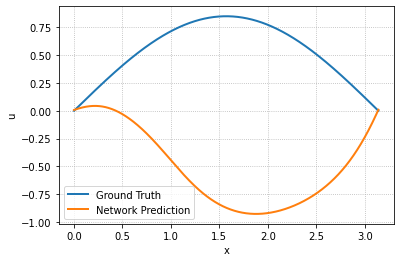

In [14]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [15]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  395.83141803741455 %
